# Neural Network per IMPACT-US

## Packages

In [1]:
import sys
sys.path.insert(1, '../Machine_Learning')
sys.path.insert(2, '../')
import numpy as np
import pandas as pd
from datetime import datetime
import jupyprint.jupyprint as jp
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat

import shrimps_class

import matplotlib.pyplot as plt
from scipy.stats import  lognorm
from scipy.optimize import curve_fit

from sklearn.preprocessing import StandardScaler

## Load dataset

In [2]:
file_mat = loadmat('../Machine_Learning/accidents.mat')

## Catalogazione dataset

In [3]:
data = np.delete(file_mat['hwydata'], 0, axis=1) # Elimina i dati della prima feature perché inutile

features = np.delete(file_mat['hwyheaders'], 0, axis=1) # Elimina l'etichetta della prima feature perché inutile

# data = file_mat['hwydata']
# features = file_mat['hwyheaders']

features = [i[0] for i in features[0]]

state_names = np.array([str(array[0][0]) for array in file_mat['statelabel']])

# Per rendere stati esterni casuali
#index = np.arange(51)
#np.random.shuffle(index)
#idx_ext = index[:10]
#idx_int = index[10:]

idx_ext = [2, 44, 39, 49, 27, 46, 40, 25, 21, 5]
idx_int = [42, 32, 18, 38, 37, 3, 8, 12, 34, 7, 24, 36, 22, 41, 
		   47, 28, 14, 23, 31, 33, 35, 19, 17, 10, 26, 9, 0, 
		   6, 45, 15, 1, 43, 48, 11, 20, 16, 50, 30, 13, 29, 4]

data_ext = data[idx_ext]
data_int = data[idx_int]

state_names_ext = state_names[idx_ext]
state_names_int = state_names[idx_int]

# print('Samples:', state_names.tolist())
# print('Samples_int:', state_names_int)
# print('Samples_ext:', state_names_ext)
# print('Features:', features)


density_int = [data_int[:,features.index('Traffic fatalities')] * 100000 / data_int[:,features.index('Total Population')],
			   data_int[:,features.index('Fatalities per 100K licensed drivers')],
			   data_int[:,features.index('Fatalities per 100K registered vehicles')]
			  ]

density_ext = [data_ext[:,features.index('Traffic fatalities')] * 100000 / data_ext[:,features.index('Total Population')],
			   data_ext[:,features.index('Fatalities per 100K licensed drivers')],
			   data_ext[:,features.index('Fatalities per 100K registered vehicles')]
			  ]

# jupyprint(pd.DataFrame(data, index = [str(array[0][0]) for array in file_mat['statelabel']], columns = features ))

## Prova fit con lognorm

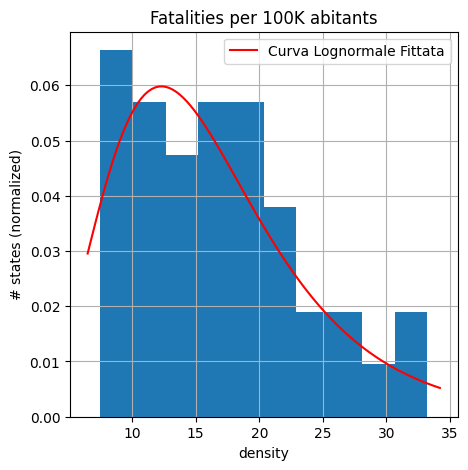

In [4]:
density = density_int[0]

frequencies, bin_edges = np.histogram(density, bins=10)  # Modifica il numero di bin se necessario

bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # punti medi dei bin

# Definisci la funzione lognormale da fittare ai dati
def lognorm_func(x, sigma, loc, scale):
	return frequencies.sum() * np.diff(bin_edges)[0] * lognorm.pdf(x, sigma, loc=loc, scale=scale)  # Il termine seguente "frequencies.sum() * np.diff(bin_edges)[0]" corrisponde all'area dell'istogramma, serve per riscalare la pdf in modo da fittarla con i nostri dati

# Fittare la curva ai dati
popt, pcov = curve_fit(lognorm_func, bin_centers, frequencies)

# Parametri ottimizzati
sigma_fit, loc_fit, scale_fit = popt

# Crea una distribuzione lognormale con i parametri fittati
x = np.linspace(min(density)-1, max(density)+1, 100)
pdf_fit = lognorm.pdf(x, sigma_fit, loc=loc_fit, scale=scale_fit)

# Plot dei dati e della curva fittata
plt.figure(figsize=(5, 5))

plt.subplot()

plt.hist(density, density=True)
plt.plot(x, pdf_fit, 'r-', label='Curva Lognormale Fittata')
plt.legend()
plt.grid()
plt.xlabel('density')
plt.ylabel('# states (normalized)')
plt.title('Fatalities per 100K abitants')
plt.show()

In [5]:
# Calcolo della seconda derivata
def second_derivative(func, x):
	h = 0.0001
	return (func(x - 2*h) - 2 * func(x - h) + func(x)) / (h ** 2)

# Calcolo dei punti in cui la concavità cambia
x_values = np.linspace(int(min(density_int[0])), int(max(density_int[0])),)  # range di valori di x da esaminare
second_derivatives = second_derivative(lambda x: lognorm_func(x, sigma_fit, loc_fit, scale_fit), x_values)
sign_changes = np.where(np.diff(np.sign(second_derivatives)))

# Stampa dei punti in cui la concavità cambia
print("Punti in cui la concavità cambia:")
for index in sign_changes:
	print("x =", x_values[index])

Punti in cui la concavità cambia:
x = [18.14285714]


## Creazione label e rimozione delle feature usate per determinare il cutoff

In [6]:
# Soglia densità per 100k abitanti (a sentimento(cambio segno derivata seconda))
cutoff = x_values[sign_changes[0][-1]]

labels_int = np.zeros(len(density_int[0]))
labels_int[density_int[0] > cutoff] = 1

labels_ext = np.zeros(len(density_ext[0]))
labels_ext[density_ext[0] > cutoff] = 1

# data_int = np.delete(data_int, features.index('Fatalities per 100K registered vehicles'), axis=1) # Elimina i dati degli incidenti perchè usati per la label
# data_ext = np.delete(data_ext, features.index('Fatalities per 100K registered vehicles'), axis=1) #
# del features[features.index('Fatalities per 100K registered vehicles')]                           #

data_int = np.delete(data_int, features.index('Traffic fatalities'), axis=1) # Elimina i dati degli incidenti perchè usati per la label
data_ext = np.delete(data_ext, features.index('Traffic fatalities'), axis=1) #
del features[features.index('Traffic fatalities')]                           #

data_int = np.delete(data_int, features.index('Total Population'), axis=1) # Elimina i dati della popolazione totale perchè usati per la label
data_ext = np.delete(data_ext, features.index('Total Population'), axis=1) #
del features[features.index('Total Population')]                           #


scaler = StandardScaler()
data_int = scaler.fit_transform(data_int)
data_ext = scaler.fit_transform(data_ext)

## PCA 

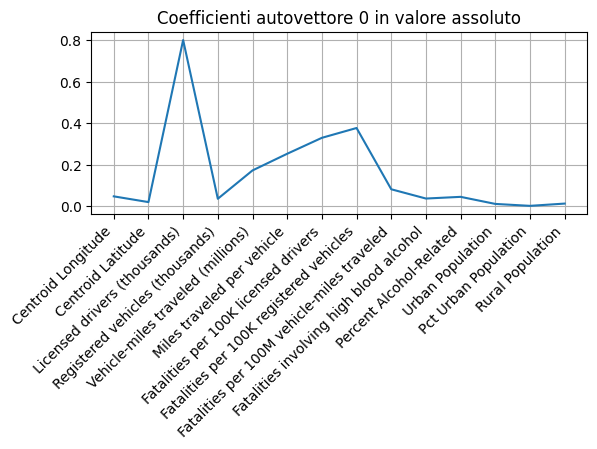

In [7]:
PCA = shrimps_class.PCA_Class(data_int, data_ext, features)
cov_mat = PCA.get_cov_mat(show_tb = False)
eval    = PCA.get_eval(show_tb = False)
evec    = PCA.get_evec(show_tb = False)

# PCA.show_eval_percent()

t = 0.96

PCA_data    	= PCA.get_PCA_data(t, show_tb = False)
PCA_data_int 	= PCA_data['pca_data_int']
PCA_data_ext 	= PCA_data['pca_data_ext']

PCA.show_evec(0)

# Rete singola

## Training

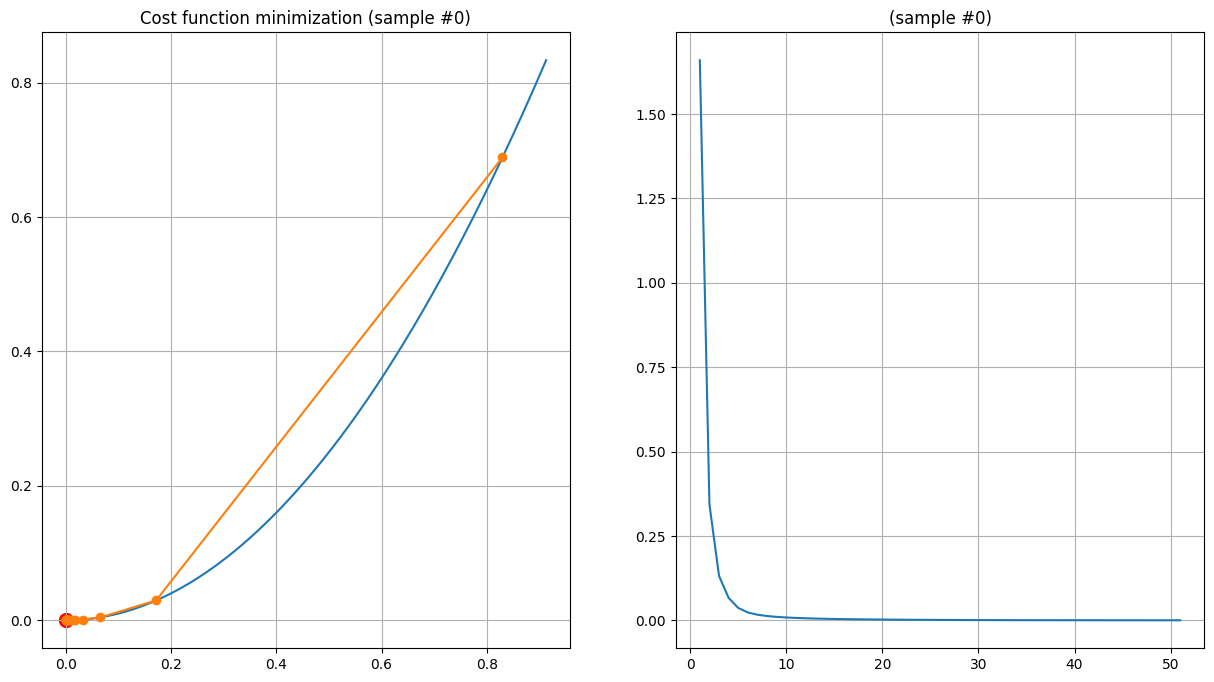

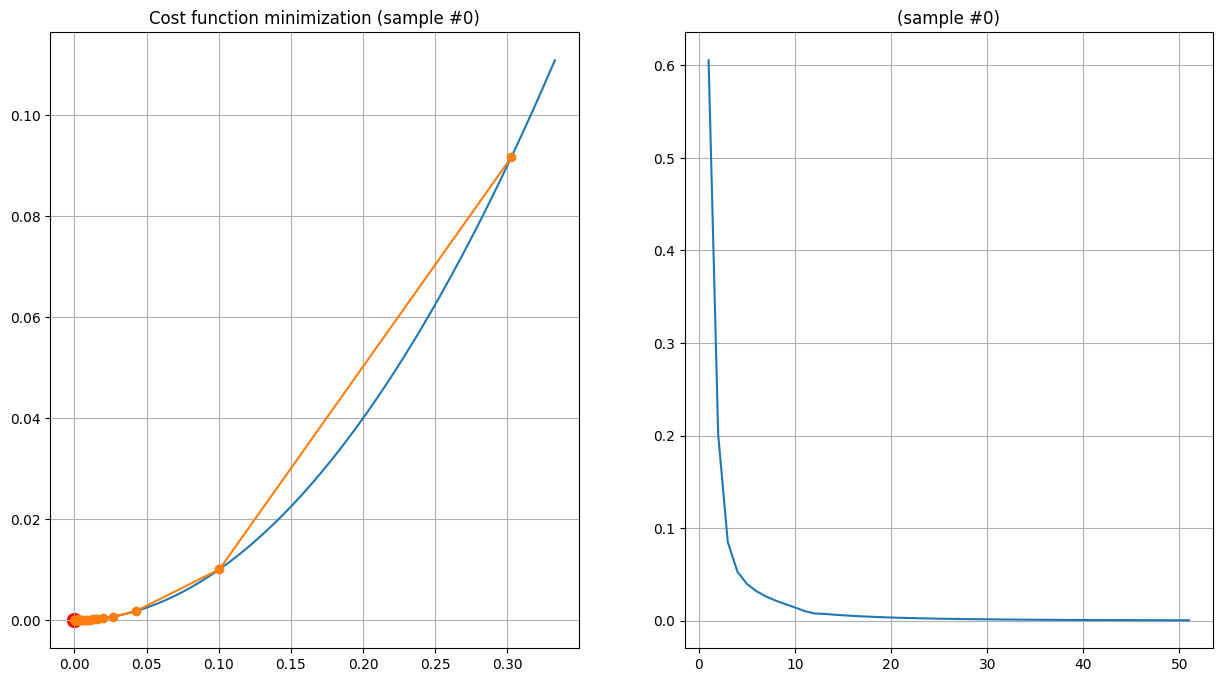

In [8]:
weights         = 2 * np.random.rand(len(data_int[0])) - 1                # crea una matrice con numeri casuali tra -1 e 1
PCA_weights     = 2 * np.random.rand(len(PCA_data_int[0])) - 1                # crea una matrice con numeri casuali tra -1 e 1
epochs          = 50
LR              = 0.1

NN = shrimps_class.NN_Class()

results = NN.training(weights, data_int, labels_int, epochs, LR)
PCA_results = NN.training(PCA_weights, PCA_data_int, labels_int, epochs, LR)
NN.plt_epochs(results = results, idx_sample = 0)
NN.plt_epochs(results = PCA_results, idx_sample = 0)

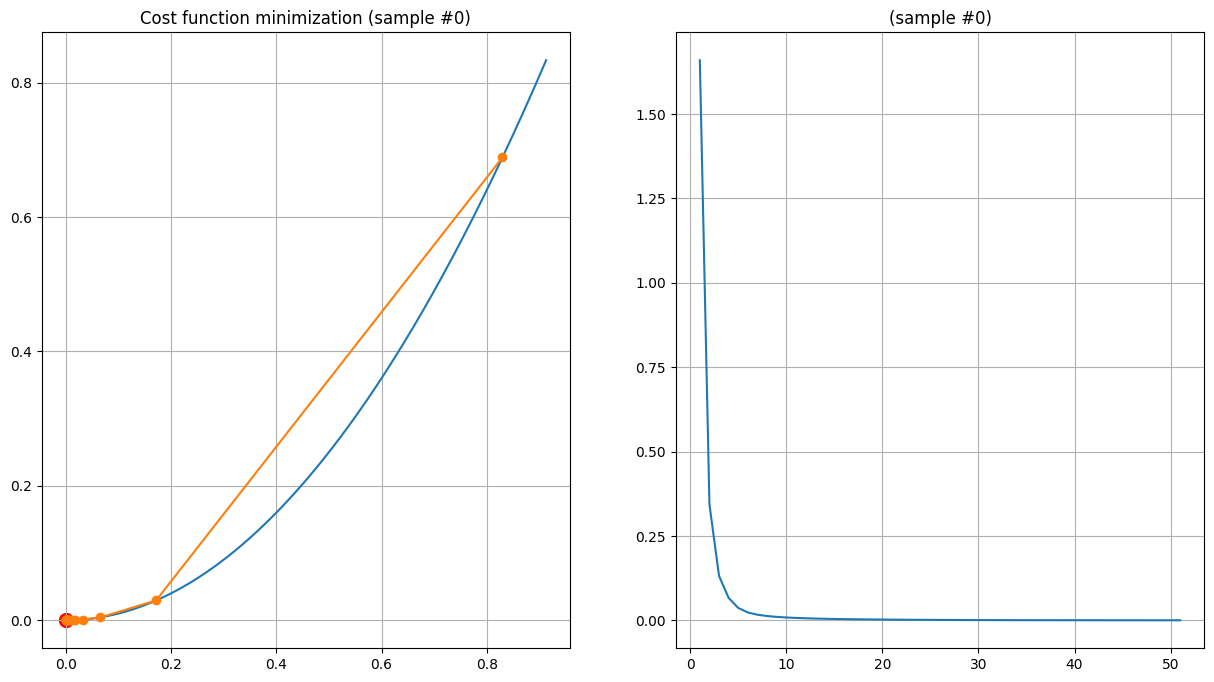

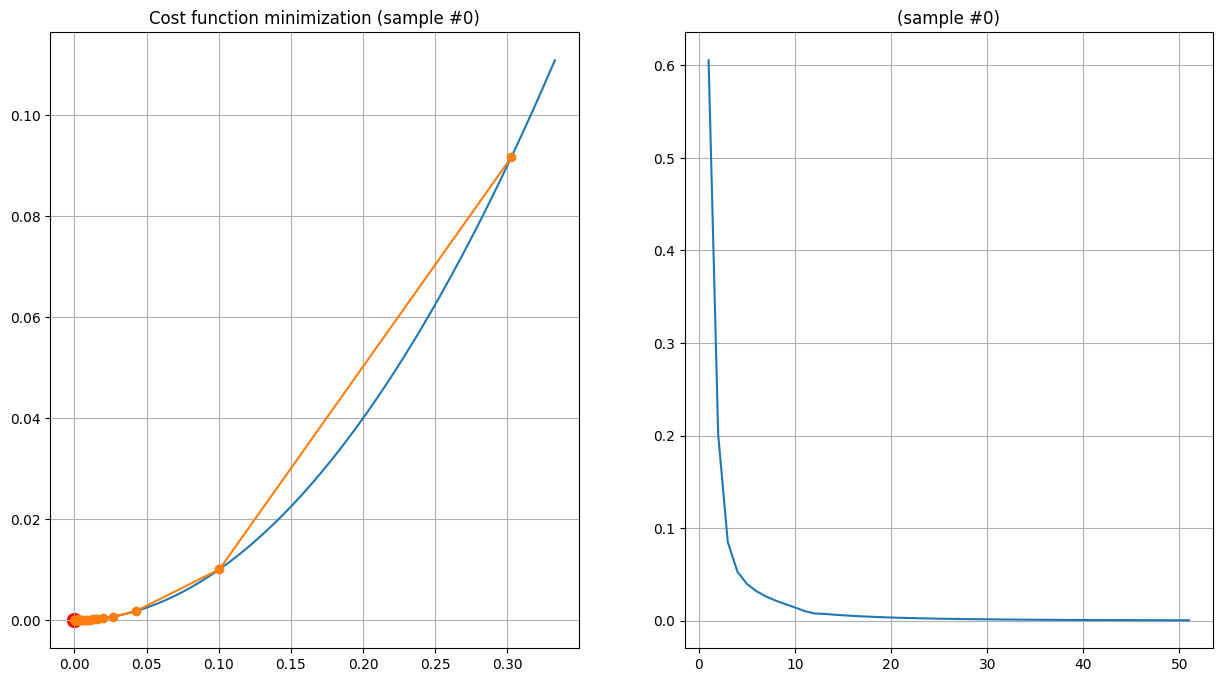

In [9]:
# Per allenare ulteriormente
results = NN.training(weights, data_int, labels_int, epochs, LR)
PCA_results = NN.training(PCA_weights, PCA_data_int, labels_int, epochs, LR)
NN.plt_epochs(results = results, idx_sample = 0)
NN.plt_epochs(results = PCA_results, idx_sample = 0)

## Testing esterno

no PCA

Accuracy    :  0.7999999999999999
Sensitivity :  1.0
Specificity :  0.7142857142857142
FN          :  0
FP          :  0.2857142857142857


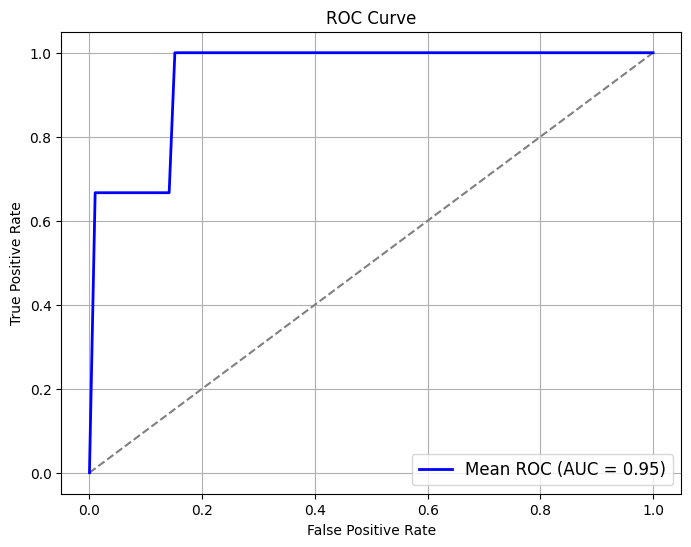



PCA

Accuracy    :  0.7999999999999999
Sensitivity :  1.0
Specificity :  0.7142857142857142
FN          :  0
FP          :  0.2857142857142857


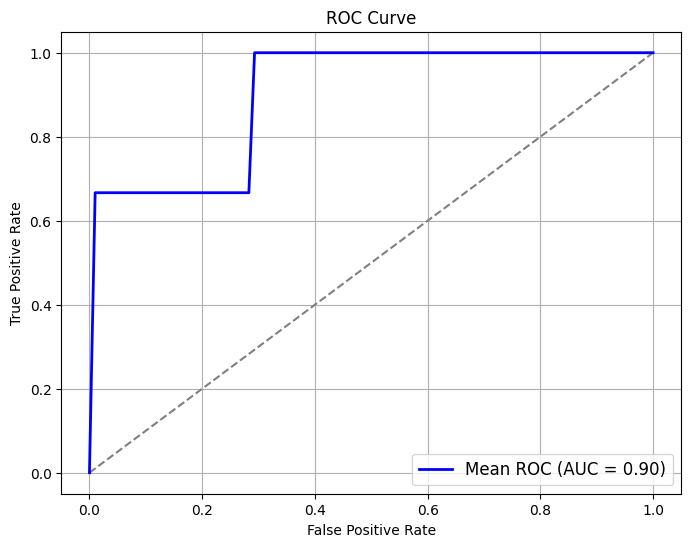

{'fpr': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
        0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
        0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
        0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
        0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
        0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
        0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
        0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
        0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
        0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
        0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
        0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
        0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
        0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
        0.70707071, 0.71717172, 0.7272727

In [10]:
tested_ext     = NN.testing(data_ext, labels_ext, results['container_weights'][-1])
PCA_tested_ext = NN.testing(PCA_data_ext, labels_ext, PCA_results['container_weights'][-1])

print('no PCA\n')
print('Accuracy    : ', tested_ext[3]['accuracy'])
print('Sensitivity : ', tested_ext[3]['sensitivity'])
print('Specificity : ', tested_ext[3]['specificity'])
print('FN          : ', tested_ext[3]['FN'])
print('FP          : ', tested_ext[3]['FP'])
NN.ROC_curve(labels_ext, tested_ext[2])

print('\n\nPCA\n')
print('Accuracy    : ', PCA_tested_ext[3]['accuracy'])
print('Sensitivity : ', PCA_tested_ext[3]['sensitivity'])
print('Specificity : ', PCA_tested_ext[3]['specificity'])
print('FN          : ', PCA_tested_ext[3]['FN'])
print('FP          : ', PCA_tested_ext[3]['FP'])
NN.ROC_curve(labels_ext, PCA_tested_ext[2])

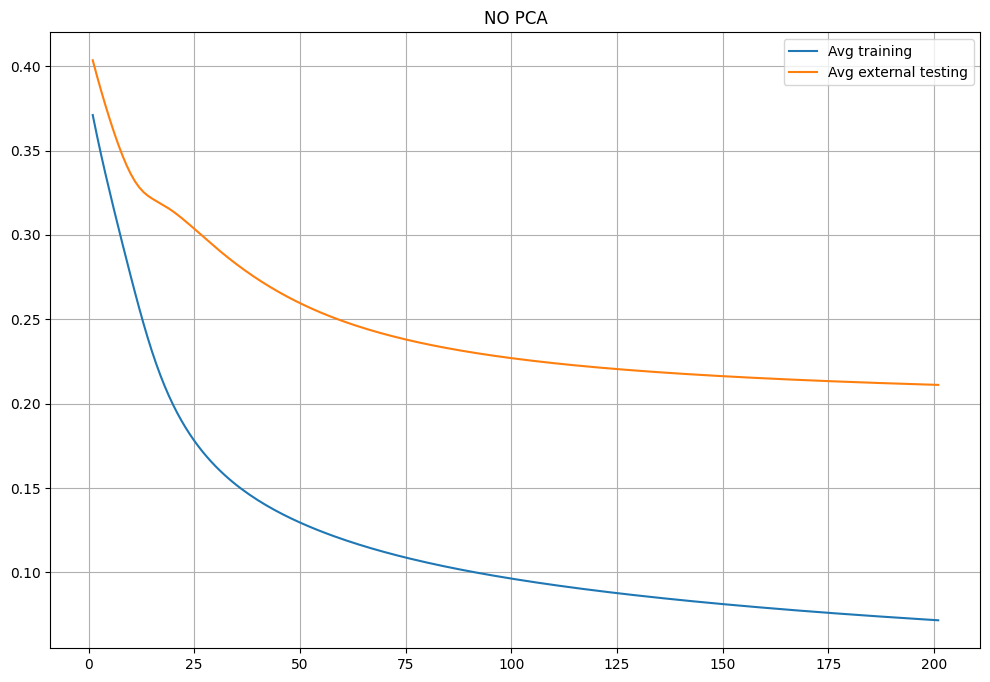

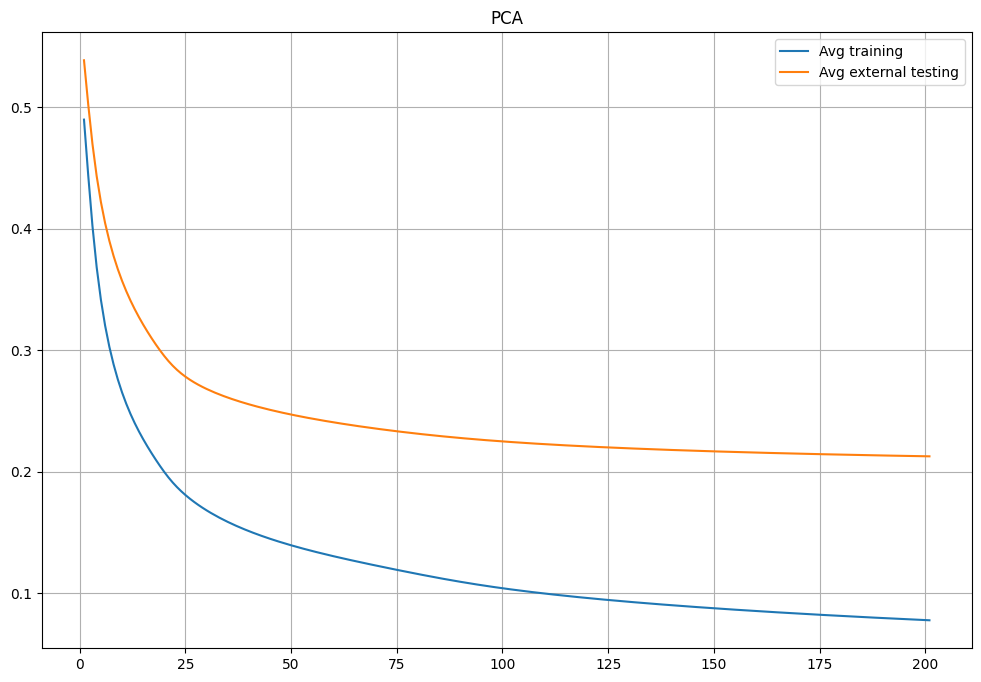

In [11]:
pd.options.display.float_format = None

weights         = 2 * np.random.rand(len(data_int[0])) - 1
PCA_weights         = 2 * np.random.rand(len(PCA_data_int[0])) - 1
epochs        	= 200
LRA             = 0.01
LRB				= 0.95

avg_tr = np.zeros(epochs + 1)
avg_ext_te = np.zeros(epochs + 1)

N = len(data_int)
original_indices = np.arange(N)

# NO PCA

results_tr = NN.training(	weights 		= weights, 
						   	inputs 			= data_int, 
							correct_outputs = labels_int, 
							epochs 			= epochs, 
							LRA				= LRA,
                            LRB				= LRB,
                            LRD				= False
    					)

P = results_tr['P']
E = results_tr['E']
avg_tr += np.sum(np.abs(P - E), axis = 0) / (len(P)) 	

# TESTING esterno

results_ext_te = NN.trend_over_epochs(
										inputs = data_ext, 
										correct_outputs = labels_ext, 
										weights_per_epoch = results_tr['container_weights']
										)

P = results_ext_te['P']
E = results_ext_te['E']
avg_ext_te = np.sum(np.abs(P - E), axis = 0) / len(P)

c_w = results_tr['container_weights']

plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, len(c_w)+1), avg_tr, label = 'Avg training')
plt.plot(np.arange(1, len(c_w)+1), avg_ext_te, label = 'Avg external testing')
plt.title('NO PCA')
plt.grid()
plt.legend()
plt.show()

# PCA

avg_tr = np.zeros(epochs + 1)
avg_ext_te = np.zeros(epochs + 1)

results_tr = NN.training(	weights 		= PCA_weights, 
						   	inputs 			= PCA_data_int, 
							correct_outputs = labels_int, 
							epochs 			= epochs, 
							LRA				= LRA,
                            LRB				= LRB,
                            LRD				= False
    					)
	
P = results_tr['P']
E = results_tr['E']
avg_tr += np.sum(np.abs(P - E), axis = 0) / (len(P)) 	

# TESTING esterno

results_ext_te = NN.trend_over_epochs(
										inputs = PCA_data_ext, 
										correct_outputs = labels_ext, 
										weights_per_epoch = results_tr['container_weights']
										)

P = results_ext_te['P']
E = results_ext_te['E']
avg_ext_te = np.sum(np.abs(P - E), axis = 0) / len(P)

c_w = results_tr['container_weights']

plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, len(c_w)+1), avg_tr, label = 'Avg training')
plt.plot(np.arange(1, len(c_w)+1), avg_ext_te, label = 'Avg external testing')
plt.title('PCA')
plt.grid()
plt.legend()
plt.show()

## Training batch

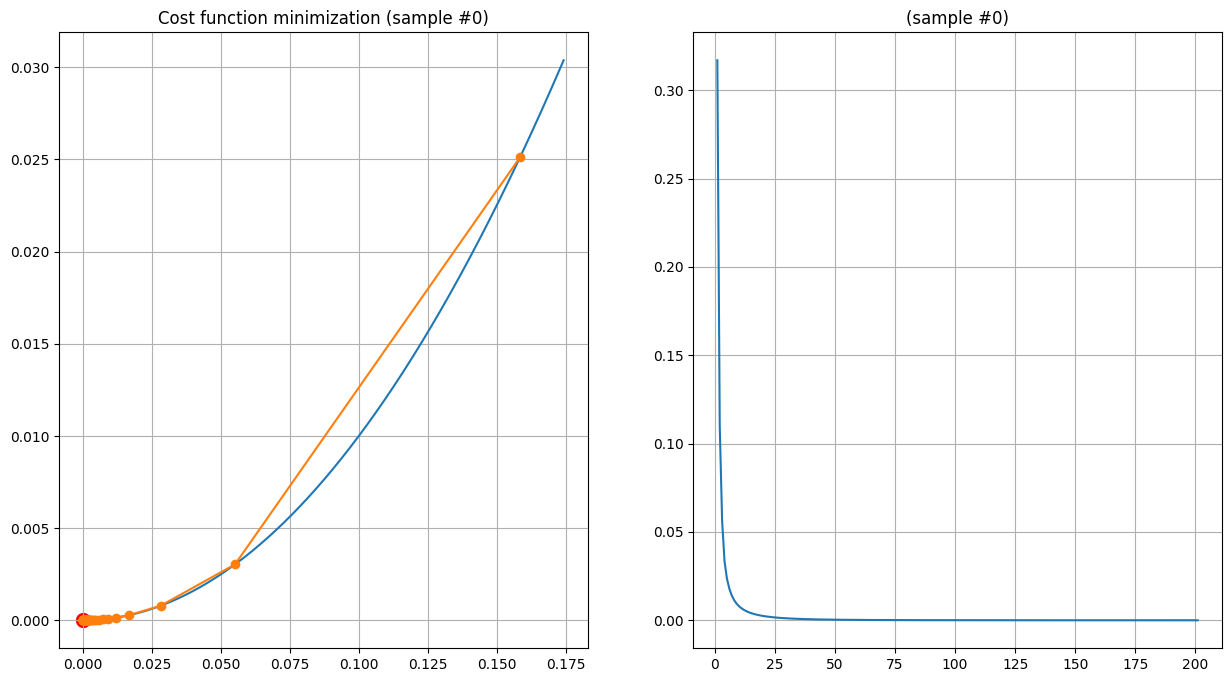

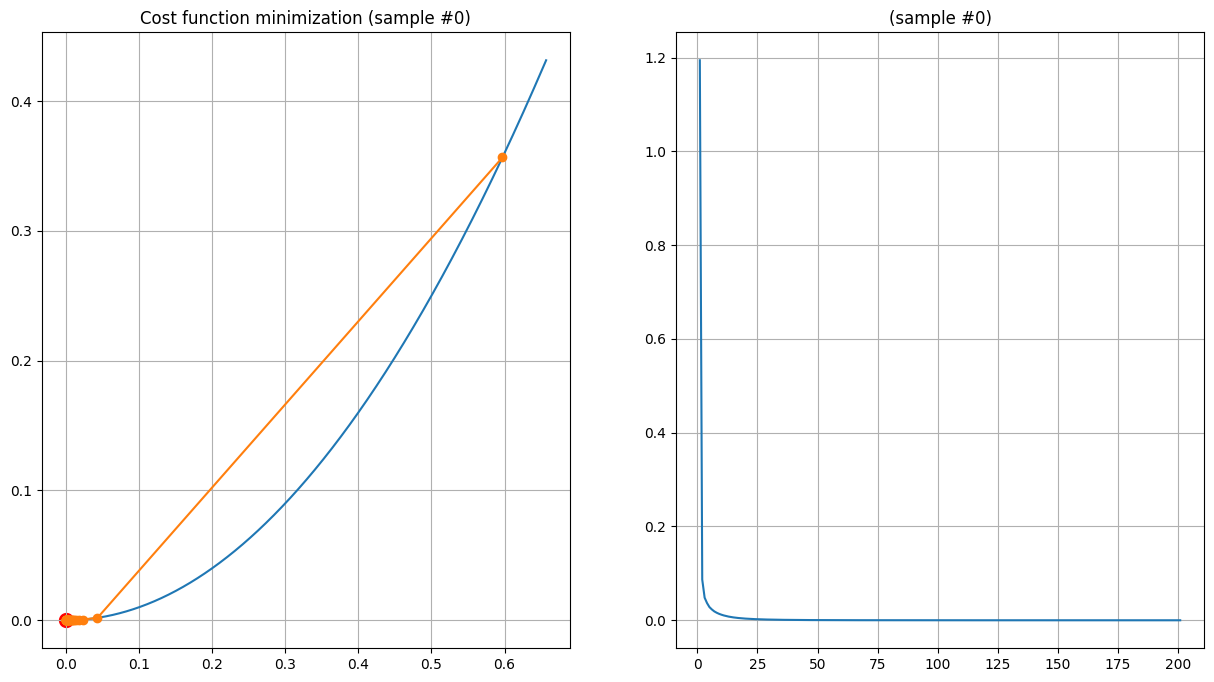

In [12]:
Batch_results = NN.training_batch(weights, data_int, labels_int, epochs, LR)
Batch_PCA_results = NN.training_batch(PCA_weights, PCA_data_int, labels_int, epochs, LR)
NN.plt_epochs(results = Batch_results, idx_sample = 0)
NN.plt_epochs(results = Batch_PCA_results, idx_sample = 0)

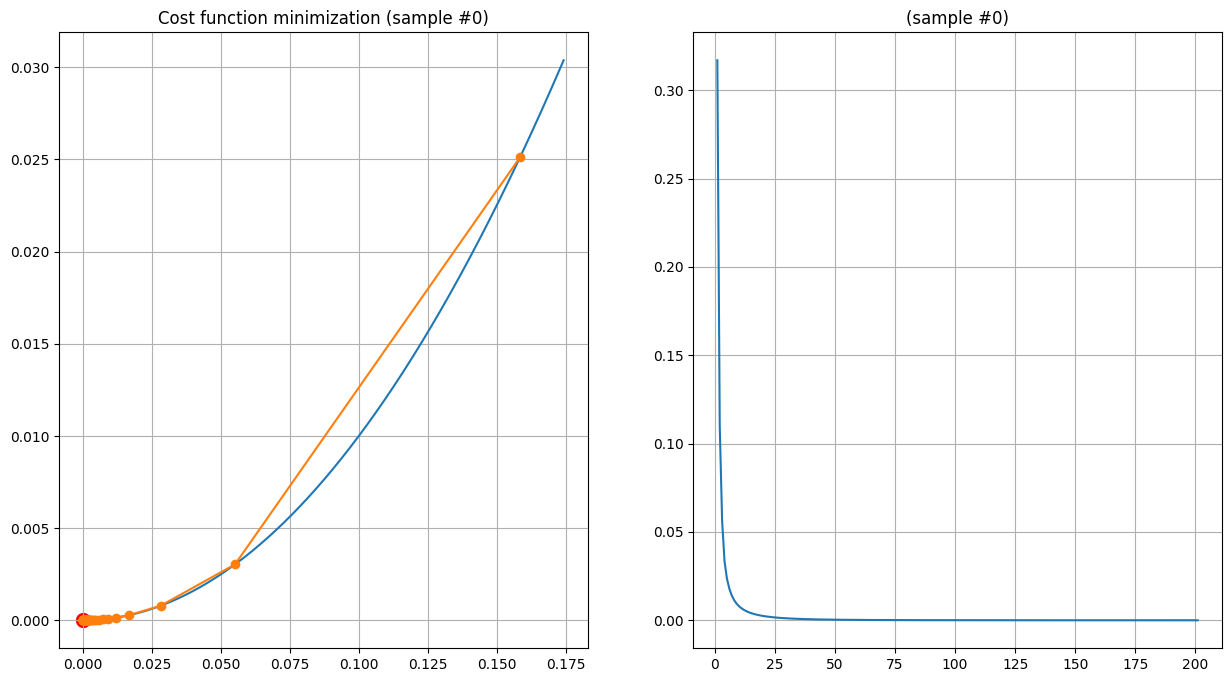

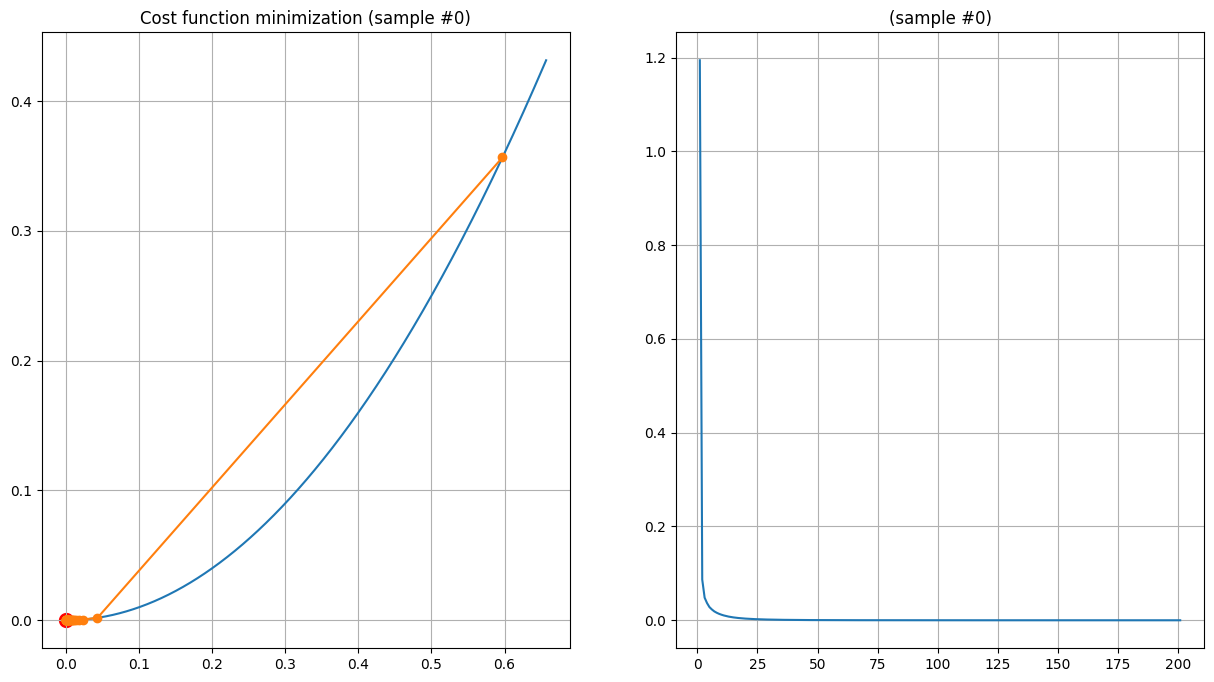

In [13]:
# Per allenare ulteriormente
Batch_results = NN.training_batch(weights, data_int, labels_int, epochs, LR)
Batch_PCA_results = NN.training_batch(PCA_weights, PCA_data_int, labels_int, epochs, LR)
NN.plt_epochs(results = Batch_results, idx_sample = 0)
NN.plt_epochs(results = Batch_PCA_results, idx_sample = 0)

## Testing esterno batch

no PCA

Accuracy    :  0.7999999999999999
Sensitivity :  1.0
Specificity :  0.7142857142857142
FN          :  0
FP          :  0.2857142857142857


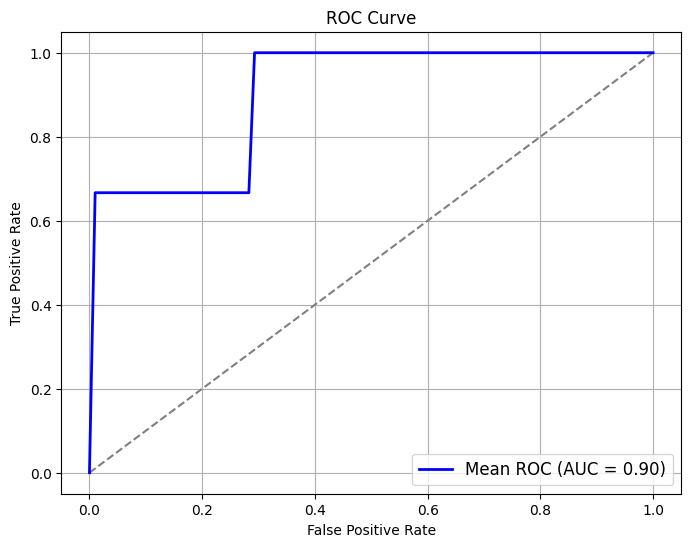



PCA

Accuracy    :  0.7999999999999999
Sensitivity :  1.0
Specificity :  0.7142857142857142
FN          :  0
FP          :  0.2857142857142857


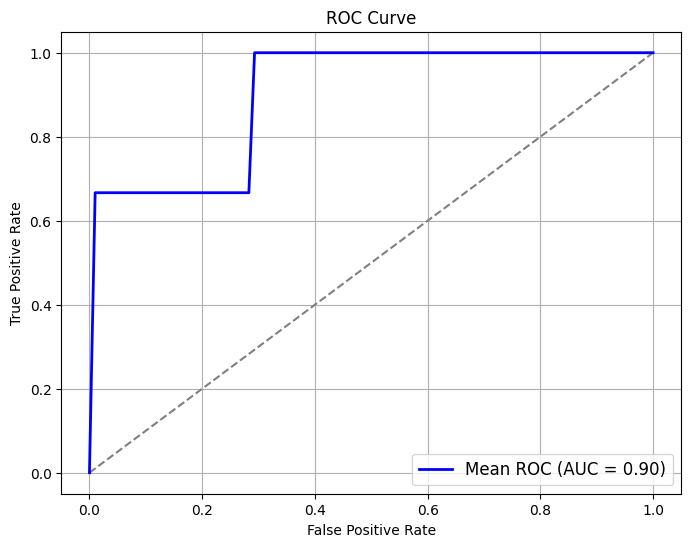

{'fpr': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
        0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
        0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
        0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
        0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
        0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
        0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
        0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
        0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
        0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
        0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
        0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
        0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
        0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
        0.70707071, 0.71717172, 0.7272727

In [14]:
tested_ext     = NN.testing(data_ext, labels_ext, Batch_results['container_weights'][-1])
PCA_tested_ext = NN.testing(PCA_data_ext, labels_ext, Batch_PCA_results['container_weights'][-1])

print('no PCA\n')
print('Accuracy    : ', tested_ext[3]['accuracy'])
print('Sensitivity : ', tested_ext[3]['sensitivity'])
print('Specificity : ', tested_ext[3]['specificity'])
print('FN          : ', tested_ext[3]['FN'])
print('FP          : ', tested_ext[3]['FP'])
NN.ROC_curve(labels_ext, tested_ext[2])

print('\n\nPCA\n')
print('Accuracy    : ', PCA_tested_ext[3]['accuracy'])
print('Sensitivity : ', PCA_tested_ext[3]['sensitivity'])
print('Specificity : ', PCA_tested_ext[3]['specificity'])
print('FN          : ', PCA_tested_ext[3]['FN'])
print('FP          : ', PCA_tested_ext[3]['FP'])
NN.ROC_curve(labels_ext, PCA_tested_ext[2])

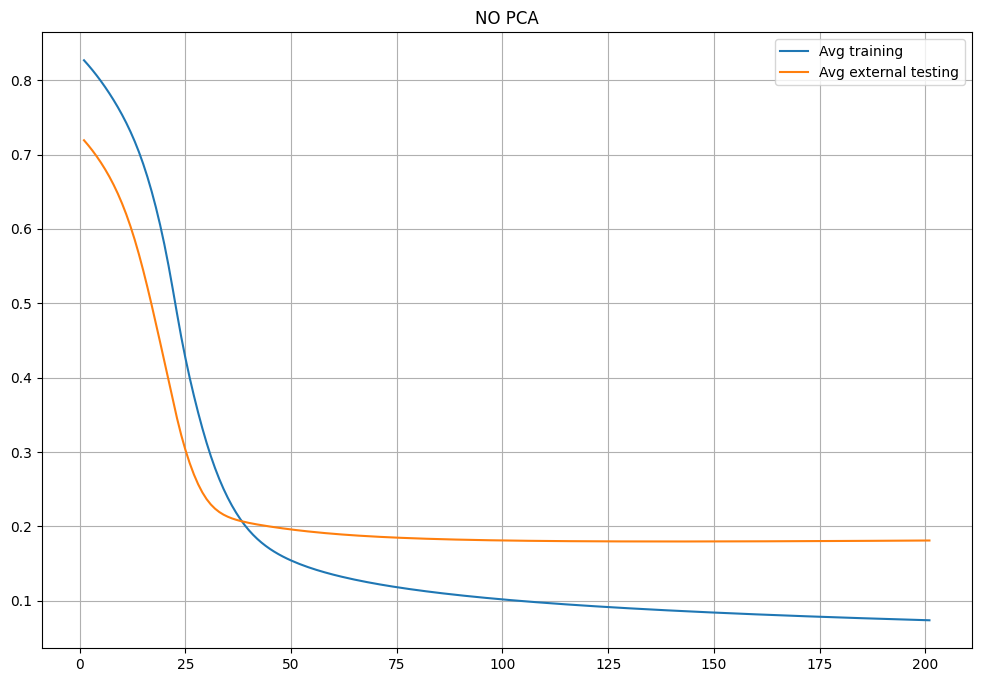

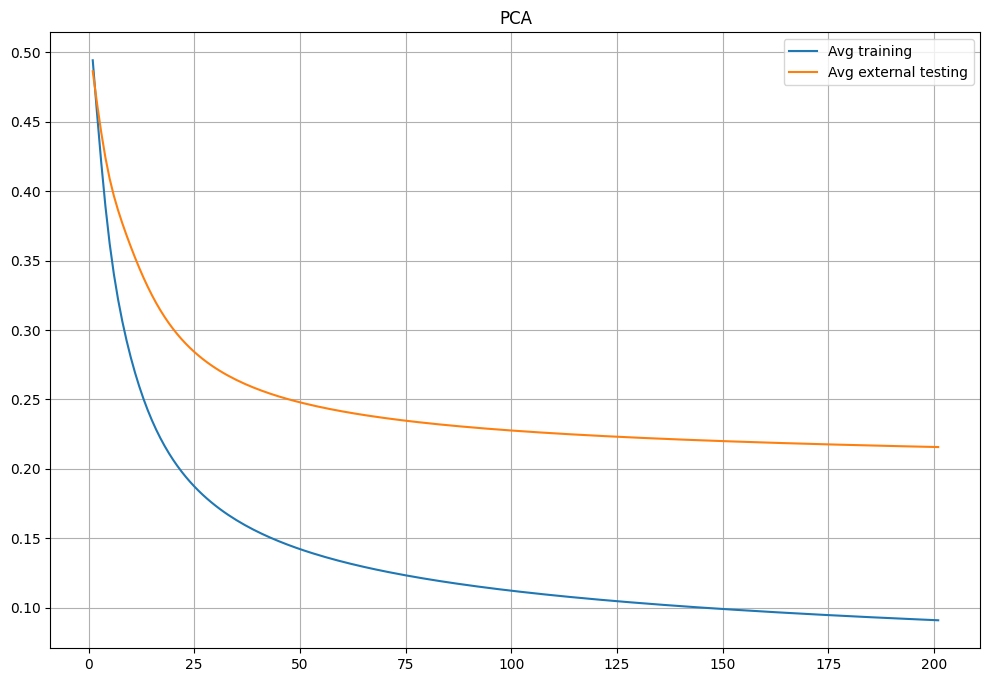

In [15]:
pd.options.display.float_format = None

weights         = 2 * np.random.rand(len(data_int[0])) - 1
PCA_weights         = 2 * np.random.rand(len(PCA_data_int[0])) - 1
epochs        	= 200
LRA             = 0.01
LRB				= 0.95

avg_tr = np.zeros(epochs + 1)
avg_ext_te = np.zeros(epochs + 1)

N = len(data_int)
original_indices = np.arange(N)

# NO PCA

results_tr = NN.training_batch(	weights 		= weights, 
						   		inputs 			= data_int, 
								correct_outputs = labels_int, 
								epochs 			= epochs, 
								LRA				= LRA,
                        	    LRB				= LRB,
                            	LRD				= False
    							)

P = results_tr['P']
E = results_tr['E']
avg_tr += np.sum(np.abs(P - E), axis = 0) / (len(P)) 	

# TESTING esterno

results_ext_te = NN.trend_over_epochs(
										inputs = data_ext, 
										correct_outputs = labels_ext, 
										weights_per_epoch = results_tr['container_weights']
										)

P = results_ext_te['P']
E = results_ext_te['E']
avg_ext_te = np.sum(np.abs(P - E), axis = 0) / len(P)

c_w = results_tr['container_weights']

plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, len(c_w)+1), avg_tr, label = 'Avg training')
plt.plot(np.arange(1, len(c_w)+1), avg_ext_te, label = 'Avg external testing')
plt.title('NO PCA')
plt.grid()
plt.legend()
plt.show()

# PCA

avg_tr = np.zeros(epochs + 1)
avg_ext_te = np.zeros(epochs + 1)

results_tr = NN.training_batch(	weights 		= PCA_weights, 
						   		inputs 			= PCA_data_int, 
								correct_outputs = labels_int, 
								epochs 			= epochs, 
								LRA				= LRA,
                            	LRB				= LRB,
                            	LRD				= False
    							)
	
P = results_tr['P']
E = results_tr['E']
avg_tr += np.sum(np.abs(P - E), axis = 0) / (len(P)) 	

# TESTING esterno

results_ext_te = NN.trend_over_epochs(
										inputs = PCA_data_ext, 
										correct_outputs = labels_ext, 
										weights_per_epoch = results_tr['container_weights']
										)

P = results_ext_te['P']
E = results_ext_te['E']
avg_ext_te = np.sum(np.abs(P - E), axis = 0) / len(P)

c_w = results_tr['container_weights']

plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, len(c_w)+1), avg_tr, label = 'Avg training')
plt.plot(np.arange(1, len(c_w)+1), avg_ext_te, label = 'Avg external testing')
plt.title('PCA')
plt.grid()
plt.legend()
plt.show()

# K reti - NO PCA

## Test variando K

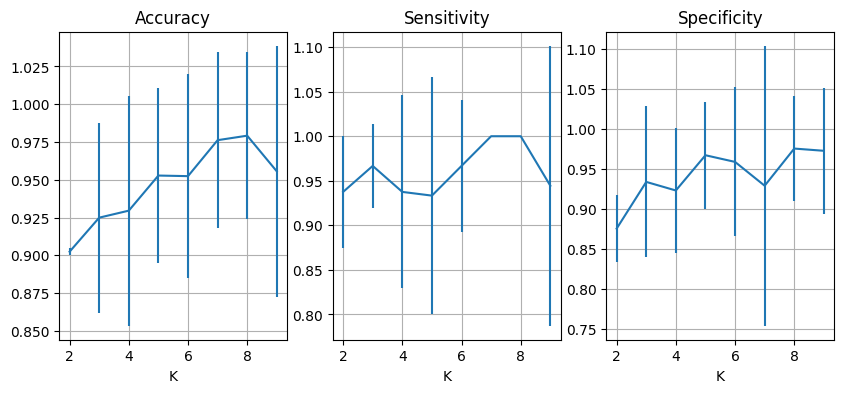

In [33]:
pd.options.display.float_format = None

k1 = 2
k2 = 10

inputs         	= data_int
weight          = 2 * np.random.rand(len(inputs[0])) - 1
weights         = np.ones((k2, len(inputs[0]))) * weight
correct_outputs = labels_int               
epochs          = 50
LRA             = 0.01
LRB				= 0.95
LRD				= False

N = len(correct_outputs)

original_indices = np.arange(N)

ACC = np.zeros(k2-k1)
ACC_err = np.zeros(k2-k1)
SENS = np.zeros(k2-k1)
SENS_err = np.zeros(k2-k1)
SPEC = np.zeros(k2-k1)
SPEC_err = np.zeros(k2-k1)

for k in range(k1,k2):
  
  fd_2 = NN.data_folding(k, N)
  
  accuracy = np.zeros(k)
  sensitivity = np.zeros(k)
  specificity = np.zeros(k)
  FP = np.zeros(k)
  FN = np.zeros(k)

  for ind in range(k):
    
    temp_train_set = np.ones(inputs.shape[0], dtype=bool)

    temp_train_set[fd_2[1] == ind] = False
    temp_test_set = ~temp_train_set
    
    temp_train_indices = original_indices[temp_train_set]
    temp_test_indices = original_indices[temp_test_set]
    
    temp_train_labels = correct_outputs[temp_train_indices]
    temp_test_labels = correct_outputs[temp_test_indices]
    
    temp_train_data = inputs[temp_train_indices, :]
    temp_test_data = inputs[temp_test_indices, :]
    
    pc_tr_data = np.squeeze(temp_train_data)
      
    results = NN.training(weights[ind,:], pc_tr_data, temp_train_labels, epochs, LRA = LRA, LRB = LRB, LRD = LRD)
    weights[ind, :] = results['container_weights'][-1]
    
    # TESTING phase
    temp_te_data = np.squeeze(temp_test_data)
    
    tested = NN.testing(temp_te_data, temp_test_labels, weights[ind, :])
    accuracy[ind] = tested[3]['accuracy']
    sensitivity[ind] = tested[3]['sensitivity']
    specificity[ind] = tested[3]['specificity']
    FP[ind] = tested[3]['FP']
    FN[ind] = tested[3]['FN']

  results_2 = {'Accuracy' : accuracy,
              'Sensitivity' : sensitivity, 
              'Specificity' : specificity,
              'FP' : FP,
              'FN' : FN}
  
  avg_results_2 = NN.avg_std_kfolds(results_2, table = False)

  ACC[k-k1] = avg_results_2['Avg']['Accuracy']
  ACC_err[k-k1] = avg_results_2['Std']['Accuracy']

  SENS[k-k1] = avg_results_2['Avg']['Sensitivity']
  SENS_err[k-k1] = avg_results_2['Std']['Sensitivity']

  SPEC[k-k1] = avg_results_2['Avg']['Specificity']
  SPEC_err[k-k1] = avg_results_2['Std']['Specificity']

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.errorbar(range(k1,k2), ACC, ACC_err)
plt.title('Accuracy')
plt.xlabel('K')
plt.grid()

plt.subplot(1, 3, 2)
plt.errorbar(range(k1,k2), SENS, SENS_err)
plt.title('Sensitivity')
plt.xlabel('K')
plt.grid()

plt.subplot(1, 3, 3)
plt.errorbar(range(k1,k2), SPEC, SPEC_err)
plt.title('Specificity')
plt.xlabel('K')
plt.grid()

plt.show()

## Training

K =  0
Accuracy    :  1.0000000000000002
Sensitivity :  1.0
Specificity :  0.9999999999999998
FN          :  0.0
FP          :  0.0 



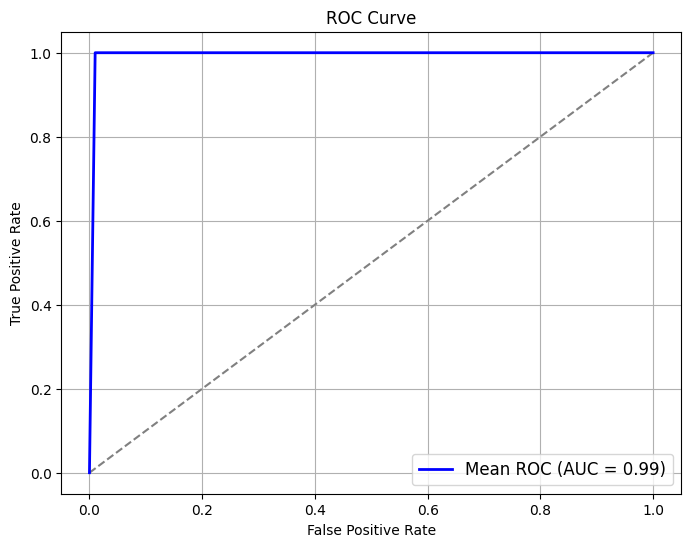

K =  1
Accuracy    :  0.9999999999999999
Sensitivity :  1.0
Specificity :  1.0
FN          :  0.0
FP          :  0.0 



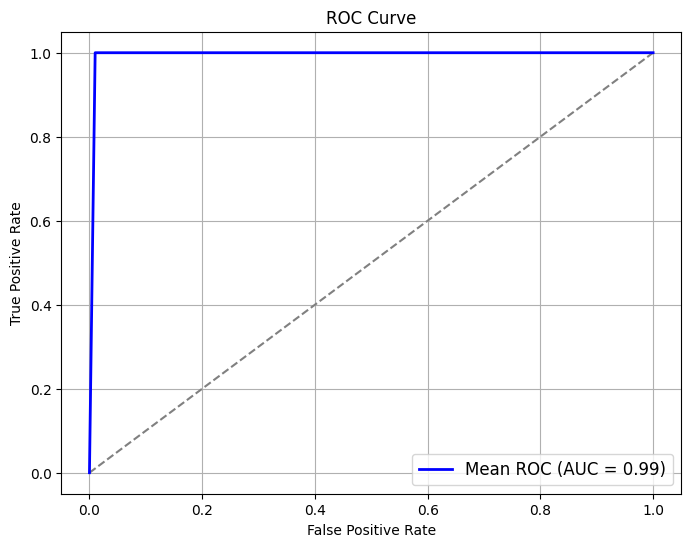

K =  2
Accuracy    :  0.8999999999999999
Sensitivity :  0.75
Specificity :  0.9999999999999999
FN          :  0.25
FP          :  0.0 



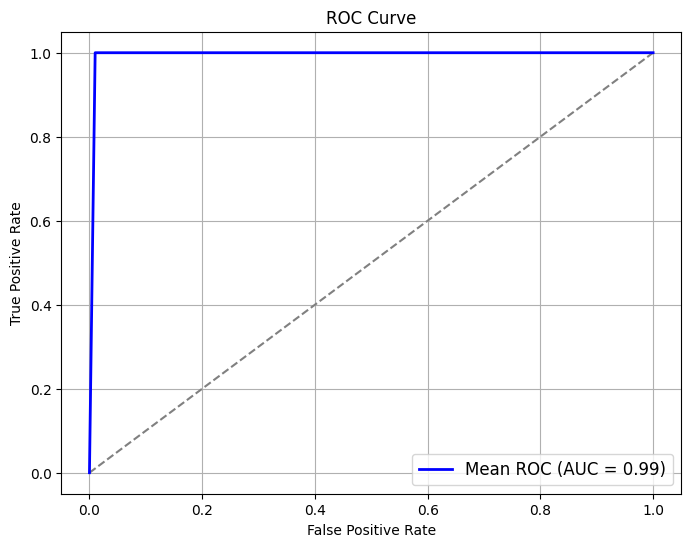

K =  3
Accuracy    :  0.7999999999999999
Sensitivity :  1.0
Specificity :  0.6666666666666666
FN          :  0.0
FP          :  0.3333333333333333 



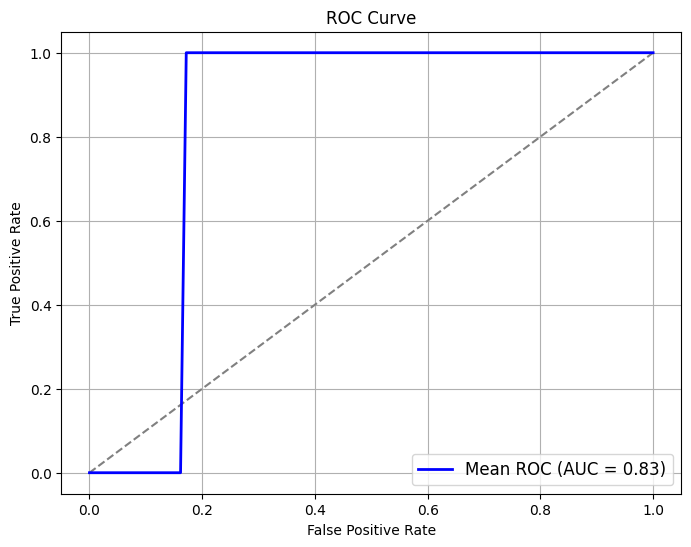

VALORI MEDI METRICHE
Accuracy    :  0.9249999999999999  +-  0.08291561975888505
Sensitivity :  0.9375  +-  0.10825317547305482
Specificity :  0.9166666666666665  +-  0.1443375672974064
FN          :  0.0625  +-  0.10825317547305482
FP          :  0.08333333333333333  +-  0.14433756729740643


In [34]:
pd.options.display.float_format = None

K = 4

inputs         	= data_int
weight          = 2 * np.random.rand(len(inputs[0])) - 1
weights         = np.ones((K, len(inputs[0]))) * weight
correct_outputs = labels_int               
epochs          = 50
LRA             = 0.01
LRB				= 0.95
LRD				= False

N = len(correct_outputs)

original_indices = np.arange(N)

fd = NN.data_folding(K, N)

K, index = fd

accuracy = np.zeros(4)
sensitivity = np.zeros(4)
specificity = np.zeros(4)
FN = np.zeros(4)
FP = np.zeros(4)

for ind in range(K):
	temp_train_set = np.ones(inputs.shape[0], dtype=bool)

	temp_train_set[index == ind] = False
	temp_test_set = ~temp_train_set
	
	temp_train_indices = original_indices[temp_train_set]
	temp_test_indices = original_indices[temp_test_set]
	
	temp_train_labels = correct_outputs[temp_train_indices]
	temp_test_labels = correct_outputs[temp_test_indices]
	
	temp_train_data = inputs[temp_train_indices, :]
	temp_test_data = inputs[temp_test_indices, :]
	
	pc_tr_data = np.squeeze(temp_train_data)
		
	results = NN.training(weights[ind,:], pc_tr_data, temp_train_labels, epochs, LRA = LRA, LRB = LRB, LRD = LRD)
	weights[ind, :] = results['container_weights'][-1]
	
	# TESTING phase
	temp_te_data = np.squeeze(temp_test_data)
	
	tested = NN.testing(temp_te_data, temp_test_labels, weights[ind, :])
	
	accuracy[ind] = tested[3]['accuracy']
	sensitivity[ind] = tested[3]['sensitivity']
	specificity[ind] = tested[3]['specificity']
	FN[ind] = tested[3]['FN']
	FP[ind] = tested[3]['FP']

	print('K = ', ind)
	print('Accuracy    : ', accuracy[ind])
	print('Sensitivity : ', sensitivity[ind])
	print('Specificity : ', specificity[ind])
	print('FN          : ', FN[ind])
	print('FP          : ', FP[ind], '\n')
	NN.ROC_curve(tested[1], tested[2])


accuracy_mean = np.mean(accuracy)
accuracy_std  = np.std(accuracy)

sensitivity_mean = np.mean(sensitivity)
sensitivity_std  = np.std(sensitivity)

specificity_mean = np.mean(specificity)
specificity_std  = np.std(specificity)

FN_mean = np.mean(FN)
FN_std  = np.std(FN)

FP_mean = np.mean(FP)
FP_std  = np.std(FP)

print('VALORI MEDI METRICHE')
print('Accuracy    : ', accuracy_mean, ' +- ', accuracy_std)
print('Sensitivity : ', sensitivity_mean, ' +- ', sensitivity_std)
print('Specificity : ', specificity_mean, ' +- ', specificity_std)
print('FN          : ', FN_mean, ' +- ', FN_std)
print('FP          : ', FP_mean, ' +- ', FP_std)

## Cost function variando epoche

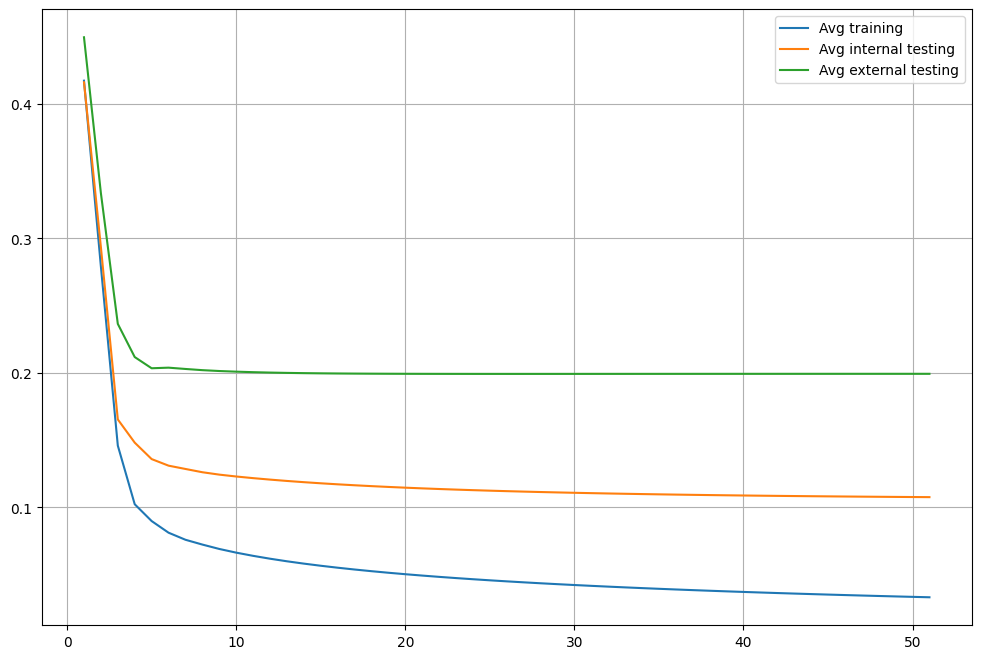

In [35]:
pd.options.display.float_format = None

K = 6

inputs         	= data_int
weights         = 2 * np.random.rand(K, len(inputs[0])) - 1
correct_outputs = labels_int
epochs        	= 50
LRA             = 0.01
LRB				= 0.95
LRD				= False

results_tr = np.zeros(K, dtype = object)
results_te = np.zeros(K, dtype = object)
results_ext_te = np.zeros(K, dtype = object)
P_ext = np.zeros((len(data_ext), epochs + 1), dtype = object)
avg_tr = np.zeros(epochs + 1)
avg_te = np.zeros(epochs + 1)

N = len(correct_outputs)
original_indices = np.arange(N)

indices = NN.data_folding(K, N)[1]


for ind in range(K):
	bool_train_set 					= np.ones(inputs.shape[0], dtype=bool)

	# Training data
	bool_train_set[indices == ind] 	= False
	train_indices 					= original_indices[bool_train_set]
	train_labels 					= correct_outputs[train_indices]
	train_data 						= inputs[train_indices, :]
	
	# Testing data
	bool_test_set 					= ~bool_train_set
	test_indices 					= original_indices[bool_test_set]
	test_labels 					= correct_outputs[test_indices]	
	test_data 						= inputs[test_indices, :]
	

	# TRAINING phase
	sq_tr_data = np.squeeze(train_data)
	results_tr[ind] = NN.training(
								weights 		= weights[ind, :], 
							   	inputs 			= sq_tr_data, 
							   	correct_outputs = train_labels, 
							   	epochs 			= epochs, 
							   	LRA 			= LRA,
								LRB				= LRB,
								LRD				= True
								)
	
	P = results_tr[ind]['P']
	E = results_tr[ind]['E']
	avg_tr += np.sum(np.abs(P - E), axis = 0) / (len(P[:, 0]) * K) 	



	# TESTING phase
	results_te[ind] = NN.trend_over_epochs(
										inputs = test_data, 
										correct_outputs = test_labels, 
										weights_per_epoch = results_tr[ind]['container_weights']
										)
	P = results_te[ind]['P']
	E = results_te[ind]['E']
	avg_te += np.sum(np.abs(P - E), axis = 0) / (len(P[:, 0]) * K) 	

	# TESTING esterno

	results_ext_te[ind] = NN.trend_over_epochs(
										inputs = data_ext, 
										correct_outputs = labels_ext, 
										weights_per_epoch = results_tr[ind]['container_weights']
										)
	P_ext += results_ext_te[ind]['P'] / K


# P = results_ext_te['P']
E = results_ext_te[0]['E']
avg_ext_te = np.sum(np.abs(P_ext - E), axis = 0) / len(P_ext[:, 0])



c_w = results_tr[1]['container_weights']
# P = results_tr[1]['P'][0]
# E = results_tr[1]['E'][0]

plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, len(c_w)+1), avg_tr, label = 'Avg training')
plt.plot(np.arange(1, len(c_w)+1), avg_te, label = 'Avg internal testing')
plt.plot(np.arange(1, len(c_w)+1), avg_ext_te, label = 'Avg external testing')
plt.grid()
plt.legend()
plt.show()

In [19]:
# c_w = results_tr[0]['container_weights']

# plt.figure(figsize=(12, 8))
# # P_tr_avg = np.sum(results_tr[0]['P'], axis = 0) / len(results_tr[0]['P'])
# # E_tr_avg = np.sum(results_tr[0]['E'], axis = 0) / len(results_tr[0]['E'])										  
# plt.plot(np.arange(1, len(c_w)+1), 2*(P_tr_avg - E_tr_avg), label = 'Avg Trained')
# # plt.plot(np.arange(1, len(c_w)+1), 2*(P_te_avg - E_te_avg), label = 'Avg Tested')
# plt.legend()
# plt.show()




# plt.figure(figsize=(15, 8))

# for i in range(1, K + 1):
# 	plt.subplot(3, 2, i)
# 	x = np.arange(epochs)  
# 	plt.grid()
# 	plt.plot(x, accuracy[:,i-1], label='accuracy')
# 	plt.plot(x, sensitivity[:,i-1], label='sensitivity')
# 	plt.plot(x, specificity[:,i-1], label='specificity')
# 	plt.plot(x, FN[:,i-1], label='FN')
# 	plt.plot(x, FP[:,i-1], label='FP')
# 	plt.title('metrics, K = ' + str(i))
# 	plt.legend()

# plt.show()

# K reti - PCA

## Test variando K

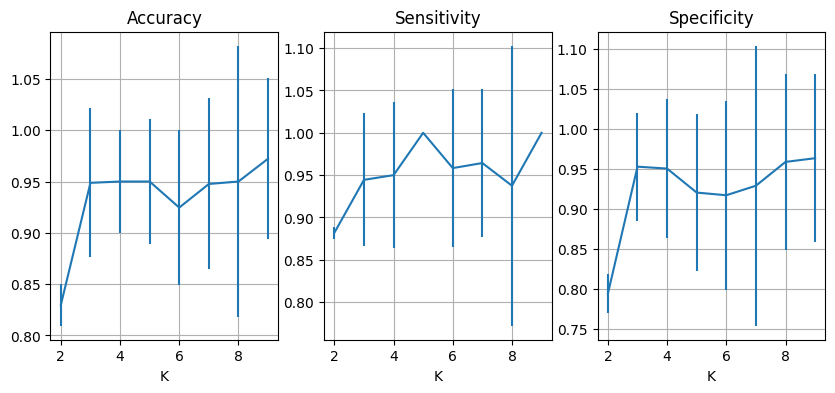

In [32]:
pd.options.display.float_format = None

k1 = 2
k2 = 10

inputs         	= PCA_data_int
weight          = 2 * np.random.rand(len(inputs[0])) - 1
weights         = np.ones((k2, len(inputs[0]))) * weight
correct_outputs = labels_int               
epochs          = 50
LRA             = 0.01
LRB				= 0.95
LRD				= False

N = len(correct_outputs)

original_indices = np.arange(N)

ACC = np.zeros(k2-k1)
ACC_err = np.zeros(k2-k1)
SENS = np.zeros(k2-k1)
SENS_err = np.zeros(k2-k1)
SPEC = np.zeros(k2-k1)
SPEC_err = np.zeros(k2-k1)

for k in range(k1,k2):
  
  fd_2 = NN.data_folding(k, N)
  
  accuracy = np.zeros(k)
  sensitivity = np.zeros(k)
  specificity = np.zeros(k)
  FP = np.zeros(k)
  FN = np.zeros(k)

  for ind in range(k):
    
    temp_train_set = np.ones(inputs.shape[0], dtype=bool)

    temp_train_set[fd_2[1] == ind] = False
    temp_test_set = ~temp_train_set
    
    temp_train_indices = original_indices[temp_train_set]
    temp_test_indices = original_indices[temp_test_set]
    
    temp_train_labels = correct_outputs[temp_train_indices]
    temp_test_labels = correct_outputs[temp_test_indices]
    
    temp_train_data = inputs[temp_train_indices, :]
    temp_test_data = inputs[temp_test_indices, :]
    
    pc_tr_data = np.squeeze(temp_train_data)
      
    results = NN.training(weights[ind,:], pc_tr_data, temp_train_labels, epochs, LRA = LRA, LRB = LRB, LRD = LRD)
    weights[ind, :] = results['container_weights'][-1]
    
    # TESTING phase
    temp_te_data = np.squeeze(temp_test_data)
    
    tested = NN.testing(temp_te_data, temp_test_labels, weights[ind, :])
    accuracy[ind] = tested[3]['accuracy']
    sensitivity[ind] = tested[3]['sensitivity']
    specificity[ind] = tested[3]['specificity']
    FP[ind] = tested[3]['FP']
    FN[ind] = tested[3]['FN']

  results_2 = {'Accuracy' : accuracy,
              'Sensitivity' : sensitivity, 
              'Specificity' : specificity,
              'FP' : FP,
              'FN' : FN}
  
  avg_results_2 = NN.avg_std_kfolds(results_2, table = False)

  ACC[k-k1] = avg_results_2['Avg']['Accuracy']
  ACC_err[k-k1] = avg_results_2['Std']['Accuracy']

  SENS[k-k1] = avg_results_2['Avg']['Sensitivity']
  SENS_err[k-k1] = avg_results_2['Std']['Sensitivity']

  SPEC[k-k1] = avg_results_2['Avg']['Specificity']
  SPEC_err[k-k1] = avg_results_2['Std']['Specificity']

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.errorbar(range(k1,k2), ACC, ACC_err)
plt.title('Accuracy')
plt.xlabel('K')
plt.grid()

plt.subplot(1, 3, 2)
plt.errorbar(range(k1,k2), SENS, SENS_err)
plt.title('Sensitivity')
plt.xlabel('K')
plt.grid()

plt.subplot(1, 3, 3)
plt.errorbar(range(k1,k2), SPEC, SPEC_err)
plt.title('Specificity')
plt.xlabel('K')
plt.grid()

plt.show()

## Cost function variando epoche

K =  0
Accuracy    :  1.0000000000000002
Sensitivity :  1.0
Specificity :  0.9999999999999999
FN          :  0.0
FP          :  0.0 



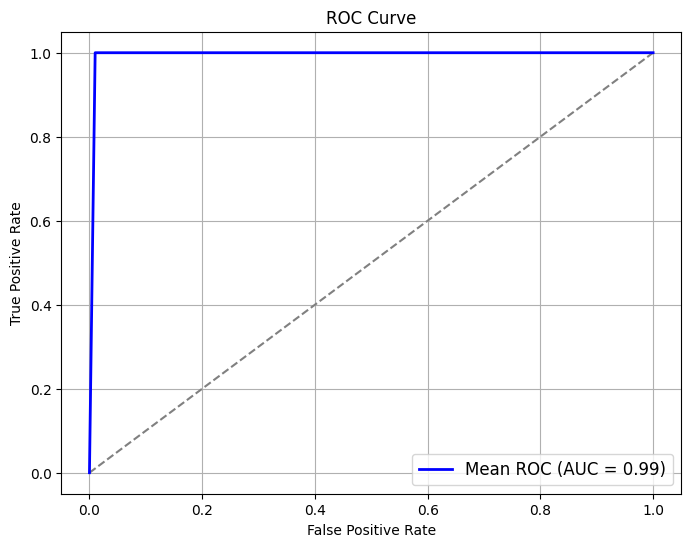

K =  1
Accuracy    :  0.7999999999999999
Sensitivity :  0.6666666666666666
Specificity :  0.857142857142857
FN          :  0.3333333333333333
FP          :  0.14285714285714285 



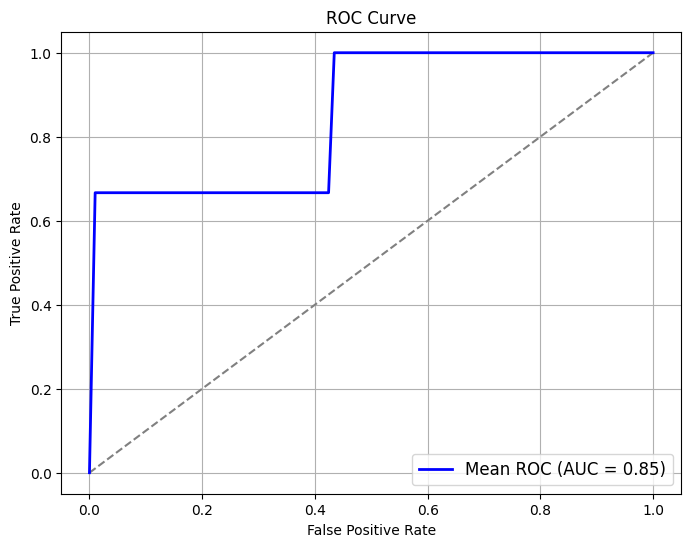

K =  2
Accuracy    :  0.8999999999999999
Sensitivity :  1.0
Specificity :  0.8
FN          :  0.0
FP          :  0.2 



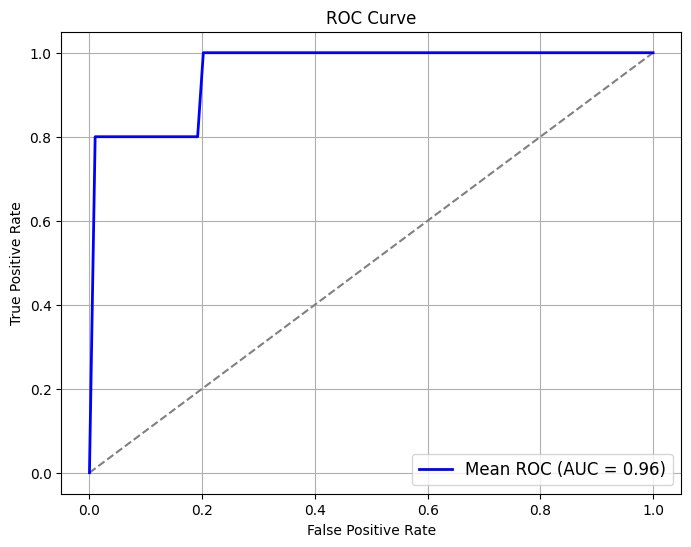

K =  3
Accuracy    :  0.8999999999999999
Sensitivity :  1.0
Specificity :  0.8333333333333333
FN          :  0.0
FP          :  0.16666666666666666 



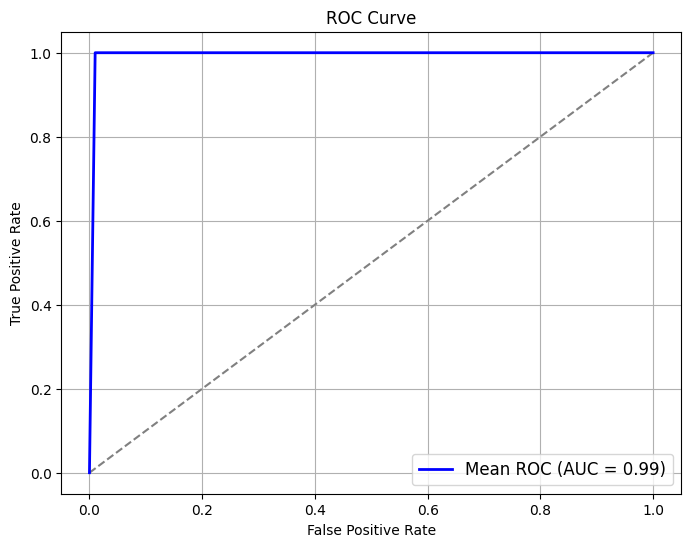

VALORI MEDI METRICHE
Accuracy    :  0.9  +-  0.07071067811865486
Sensitivity :  0.9166666666666666  +-  0.14433756729740646
Specificity :  0.8726190476190474  +-  0.07629271414291479
FN          :  0.08333333333333333  +-  0.14433756729740646
FP          :  0.12738095238095237  +-  0.07629271414291484


In [36]:
pd.options.display.float_format = None

K = 4

inputs         	= PCA_data_int
weight          = 2 * np.random.rand(len(inputs[0])) - 1
weights         = np.ones((K, len(inputs[0]))) * weight
correct_outputs = labels_int               
epochs          = 25
LRA             = 0.01
LRB				= 0.95
LRD				= False

N = len(correct_outputs)

original_indices = np.arange(N)

fd = NN.data_folding(K, N)

K, index = fd

accuracy = np.zeros(4)
sensitivity = np.zeros(4)
specificity = np.zeros(4)
FN = np.zeros(4)
FP = np.zeros(4)

for ind in range(K):
	temp_train_set = np.ones(inputs.shape[0], dtype=bool)

	temp_train_set[index == ind] = False
	temp_test_set = ~temp_train_set
	
	temp_train_indices = original_indices[temp_train_set]
	temp_test_indices = original_indices[temp_test_set]
	
	temp_train_labels = correct_outputs[temp_train_indices]
	temp_test_labels = correct_outputs[temp_test_indices]
	
	temp_train_data = inputs[temp_train_indices, :]
	temp_test_data = inputs[temp_test_indices, :]
	
	pc_tr_data = np.squeeze(temp_train_data)

	results = NN.training(weights[ind,:], pc_tr_data, temp_train_labels, epochs, LRA = LRA, LRB = LRB, LRD = LRD)
	weights[ind, :] = results['container_weights'][-1]
	
	# TESTING phase
	temp_te_data = np.squeeze(temp_test_data)
	tested = NN.testing(temp_te_data, temp_test_labels, weights[ind, :])
	
	accuracy[ind] = tested[3]['accuracy']
	sensitivity[ind] = tested[3]['sensitivity']
	specificity[ind] = tested[3]['specificity']
	FN[ind] = tested[3]['FN']
	FP[ind] = tested[3]['FP']

	print('K = ', ind)
	print('Accuracy    : ', accuracy[ind])
	print('Sensitivity : ', sensitivity[ind])
	print('Specificity : ', specificity[ind])
	print('FN          : ', FN[ind])
	print('FP          : ', FP[ind], '\n')
	NN.ROC_curve(tested[1], tested[2])

accuracy_mean = np.mean(accuracy)
accuracy_std  = np.std(accuracy)

sensitivity_mean = np.mean(sensitivity)
sensitivity_std  = np.std(sensitivity)

specificity_mean = np.mean(specificity)
specificity_std  = np.std(specificity)

FN_mean = np.mean(FN)
FN_std  = np.std(FN)

FP_mean = np.mean(FP)
FP_std  = np.std(FP)

print('VALORI MEDI METRICHE')
print('Accuracy    : ', accuracy_mean, ' +- ', accuracy_std)
print('Sensitivity : ', sensitivity_mean, ' +- ', sensitivity_std)
print('Specificity : ', specificity_mean, ' +- ', specificity_std)
print('FN          : ', FN_mean, ' +- ', FN_std)
print('FP          : ', FP_mean, ' +- ', FP_std)


## Cost function variando epoche

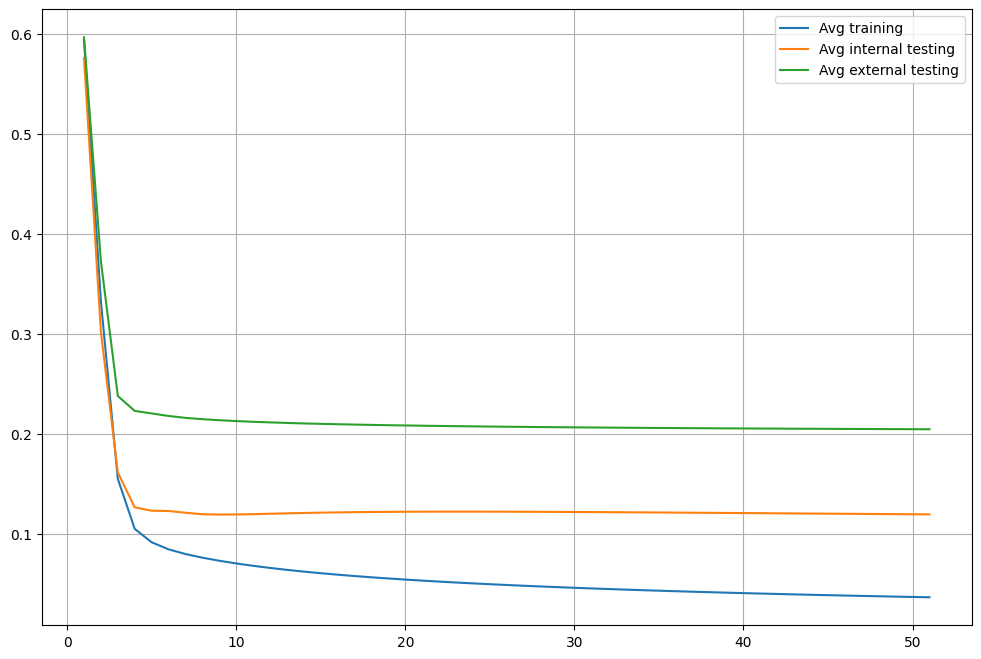

In [37]:
pd.options.display.float_format = None

K = 6

inputs         	= PCA_data_int
weights         = 2 * np.random.rand(K, len(inputs[0])) - 1
correct_outputs = labels_int
epochs        	= 50
LRA             = 0.01
LRB				= 0.95
LRD				= False

results_tr = np.zeros(K, dtype = object)
results_te = np.zeros(K, dtype = object)
results_ext_te = np.zeros(K, dtype = object)
P_ext = np.zeros((len(PCA_data_ext), epochs + 1), dtype = object)
avg_tr = np.zeros(epochs + 1)
avg_te = np.zeros(epochs + 1)

N = len(correct_outputs)
original_indices = np.arange(N)

indices = NN.data_folding(K, N)[1]


for ind in range(K):
	bool_train_set 					= np.ones(inputs.shape[0], dtype=bool)

	# Training data
	bool_train_set[indices == ind] 	= False
	train_indices 					= original_indices[bool_train_set]
	train_labels 					= correct_outputs[train_indices]
	train_data 						= inputs[train_indices, :]
	
	# Testing data
	bool_test_set 					= ~bool_train_set
	test_indices 					= original_indices[bool_test_set]
	test_labels 					= correct_outputs[test_indices]	
	test_data 						= inputs[test_indices, :]
	

	# TRAINING phase
	sq_tr_data = np.squeeze(train_data)
	results_tr[ind] = NN.training(
								weights 		= weights[ind, :], 
							   	inputs 			= sq_tr_data, 
							   	correct_outputs = train_labels, 
							   	epochs 			= epochs, 
							   	LRA 			= LRA,
								LRB				= LRB,
								LRD				= True
								)
	
	P = results_tr[ind]['P']
	E = results_tr[ind]['E']
	avg_tr += np.sum(np.abs(P - E), axis = 0) / (len(P[:, 0]) * K) 	



	# TESTING phase
	results_te[ind] = NN.trend_over_epochs(
										inputs = test_data, 
										correct_outputs = test_labels, 
										weights_per_epoch = results_tr[ind]['container_weights']
										)
	P = results_te[ind]['P']
	E = results_te[ind]['E']
	avg_te += np.sum(np.abs(P - E), axis = 0) / (len(P[:, 0]) * K) 	

	# TESTING esterno

	results_ext_te[ind] = NN.trend_over_epochs(
										inputs = PCA_data_ext, 
										correct_outputs = labels_ext, 
										weights_per_epoch = results_tr[ind]['container_weights']
										)
	P_ext += results_ext_te[ind]['P'] / K


# P = results_ext_te['P']
E = results_ext_te[0]['E']
avg_ext_te = np.sum(np.abs(P_ext - E), axis = 0) / len(P_ext[:, 0])



c_w = results_tr[1]['container_weights']
# P = results_tr[1]['P'][0]
# E = results_tr[1]['E'][0]

plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, len(c_w)+1), avg_tr, label = 'Avg training')
plt.plot(np.arange(1, len(c_w)+1), avg_te, label = 'Avg internal testing')
plt.plot(np.arange(1, len(c_w)+1), avg_ext_te, label = 'Avg external testing')
plt.grid()
plt.legend()
plt.show()

# Outlier

## NO PCA

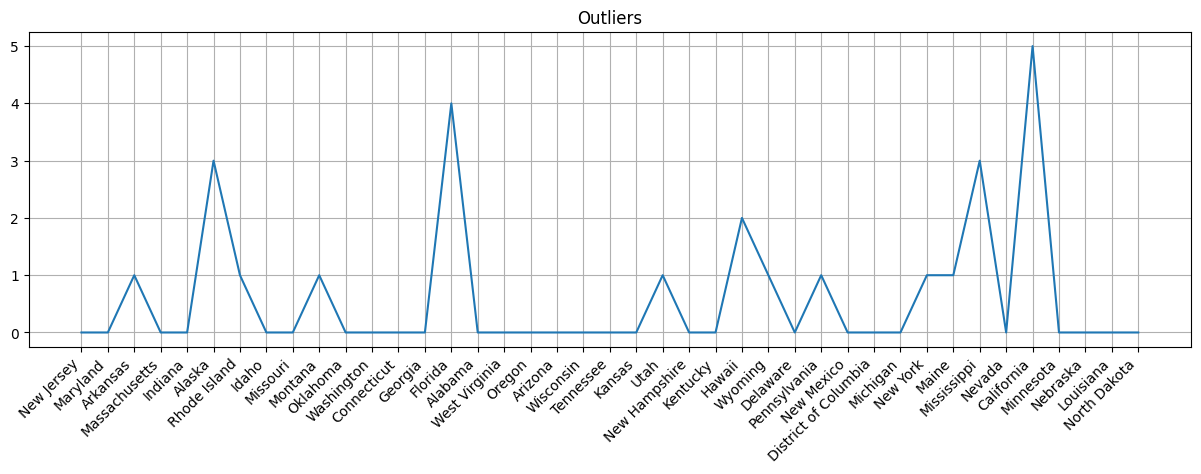

In [23]:
scaler = StandardScaler()
scaled_data_int = scaler.fit_transform(data_int)

# Ottengomo medie e deviazioni standard feature scalate
#
# feature_means = scaler.mean_
# feature_std = np.sqrt(scaler.var_)

outlier = np.zeros(len(scaled_data_int))

for i, state in enumerate(scaled_data_int):
    outlier[i] = 0
    for j, feat in enumerate(state):
        if np.abs(feat) > 2:
            outlier[i] += 1

# Visualizza outliers
plt.figure(figsize=(15, 5))
plt.title(f'Outliers')
plt.subplots_adjust(bottom=0.25)
plt.xticks(range(0,len(scaled_data_int)), state_names_int, rotation=45, ha='right')
plt.plot(outlier)
plt.grid()
plt.show()

In [24]:
# Percentuale feature outlier per essere considerato outlier
p_outlier = 0.3

# Vettore che mi indica la posizione degli outlier
outlier_idx = np.zeros(len(outlier))

for i in range(len(outlier)) :
  if outlier[i] > p_outlier * len(scaled_data_int[0]) :
    outlier_idx[i] = 1

outlier_idx = np.array(outlier_idx, dtype=bool)

out_data_int = np.delete(data_int, outlier_idx, axis=0)
out_labels_int = np.delete(labels_int, outlier_idx, axis=0)

### Training

K =  0
Accuracy    :  0.7999999999999999
Sensitivity :  1.0
Specificity :  0.7142857142857142
FN          :  0.0
FP          :  0.2857142857142857 



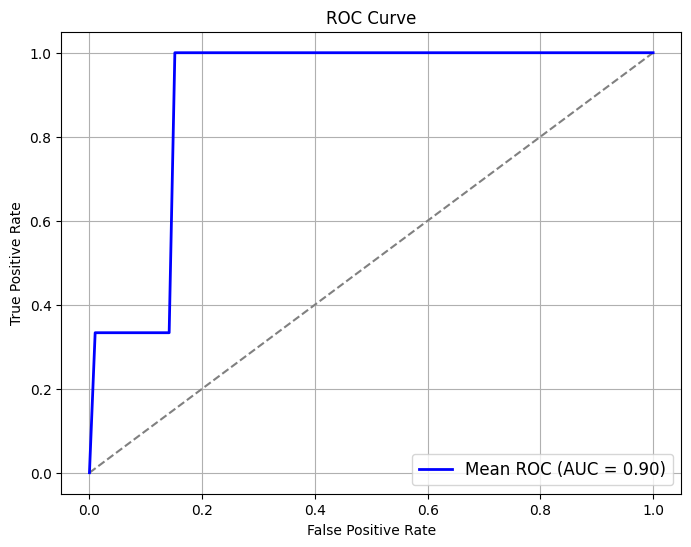

K =  1
Accuracy    :  0.8999999999999999
Sensitivity :  0.75
Specificity :  0.9999999999999999
FN          :  0.25
FP          :  0.0 



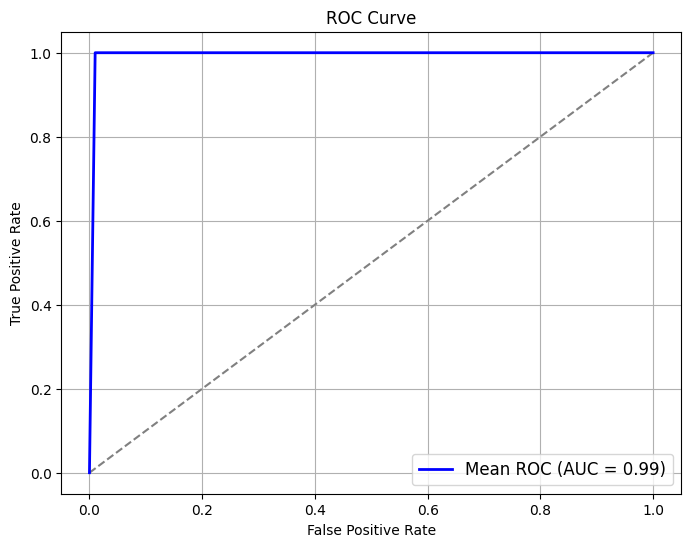

K =  2
Accuracy    :  0.9999999999999999
Sensitivity :  1.0
Specificity :  1.0
FN          :  0.0
FP          :  0.0 



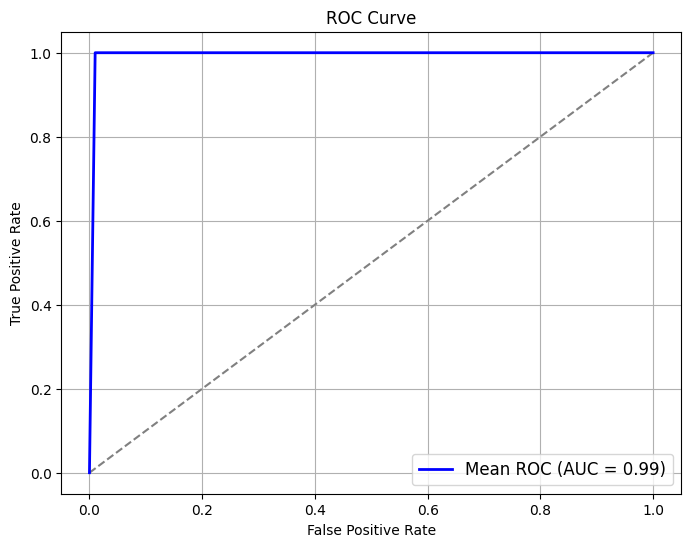

K =  3
Accuracy    :  0.8999999999999999
Sensitivity :  1.0
Specificity :  0.8
FN          :  0.0
FP          :  0.2 



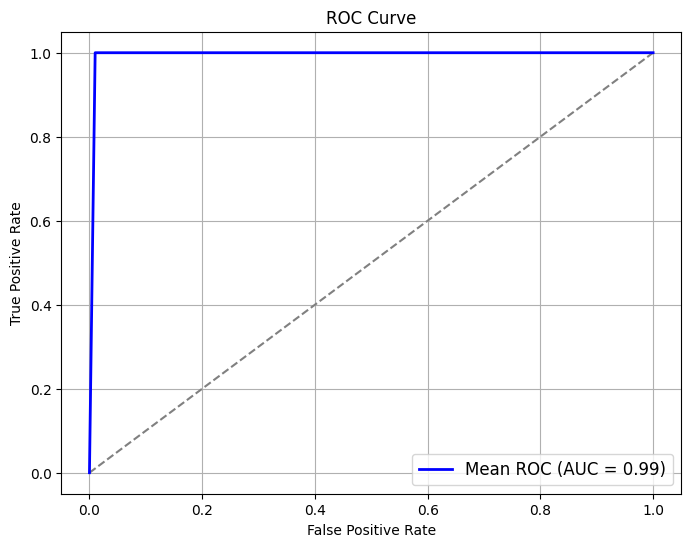

VALORI MEDI METRICHE
Accuracy    :  0.8999999999999999  +-  0.07071067811865474
Sensitivity :  0.9375  +-  0.10825317547305482
Specificity :  0.8785714285714286  +-  0.1251529676281088
FN          :  0.0625  +-  0.10825317547305482
FP          :  0.12142857142857143  +-  0.1251529676281088


In [39]:
pd.options.display.float_format = None

K = 4

inputs         	= out_data_int
weight          = 2 * np.random.rand(len(inputs[0])) - 1
weights         = np.ones((K, len(inputs[0]))) * weight
correct_outputs = out_labels_int               
epochs          = 25
LRA             = 0.01
LRB				= 0.95
LRD				= False

N = len(correct_outputs)

original_indices = np.arange(N)

fd = NN.data_folding(K, N)

K, index = fd

accuracy = np.zeros(4)
sensitivity = np.zeros(4)
specificity = np.zeros(4)
FN = np.zeros(4)
FP = np.zeros(4)

for ind in range(K):
	temp_train_set = np.ones(inputs.shape[0], dtype=bool)

	temp_train_set[index == ind] = False
	temp_test_set = ~temp_train_set
	
	temp_train_indices = original_indices[temp_train_set]
	temp_test_indices = original_indices[temp_test_set]
	
	temp_train_labels = out_labels_int[temp_train_indices]
	temp_test_labels = out_labels_int[temp_test_indices]
	
	temp_train_data = out_data_int[temp_train_indices, :]
	temp_test_data = out_data_int[temp_test_indices, :]
	
	pc_tr_data = np.squeeze(temp_train_data)
		
	results = NN.training(weights[ind,:], pc_tr_data, temp_train_labels, epochs, LRA = LRA, LRB = LRB, LRD = LRD)
	weights[ind, :] = results['container_weights'][-1]
	
	# TESTING phase
	temp_te_data = np.squeeze(temp_test_data)
	
	tested = NN.testing(temp_te_data, temp_test_labels, weights[ind, :])
	
	accuracy[ind] = tested[3]['accuracy']
	sensitivity[ind] = tested[3]['sensitivity']
	specificity[ind] = tested[3]['specificity']
	FN[ind] = tested[3]['FN']
	FP[ind] = tested[3]['FP']

	print('K = ', ind)
	print('Accuracy    : ', accuracy[ind])
	print('Sensitivity : ', sensitivity[ind])
	print('Specificity : ', specificity[ind])
	print('FN          : ', FN[ind])
	print('FP          : ', FP[ind], '\n')
	NN.ROC_curve(tested[1], tested[2])


accuracy_mean = np.mean(accuracy)
accuracy_std  = np.std(accuracy)

sensitivity_mean = np.mean(sensitivity)
sensitivity_std  = np.std(sensitivity)

specificity_mean = np.mean(specificity)
specificity_std  = np.std(specificity)

FN_mean = np.mean(FN)
FN_std  = np.std(FN)

FP_mean = np.mean(FP)
FP_std  = np.std(FP)

print('VALORI MEDI METRICHE')
print('Accuracy    : ', accuracy_mean, ' +- ', accuracy_std)
print('Sensitivity : ', sensitivity_mean, ' +- ', sensitivity_std)
print('Specificity : ', specificity_mean, ' +- ', specificity_std)
print('FN          : ', FN_mean, ' +- ', FN_std)
print('FP          : ', FP_mean, ' +- ', FP_std)


### Cost function variando epoche

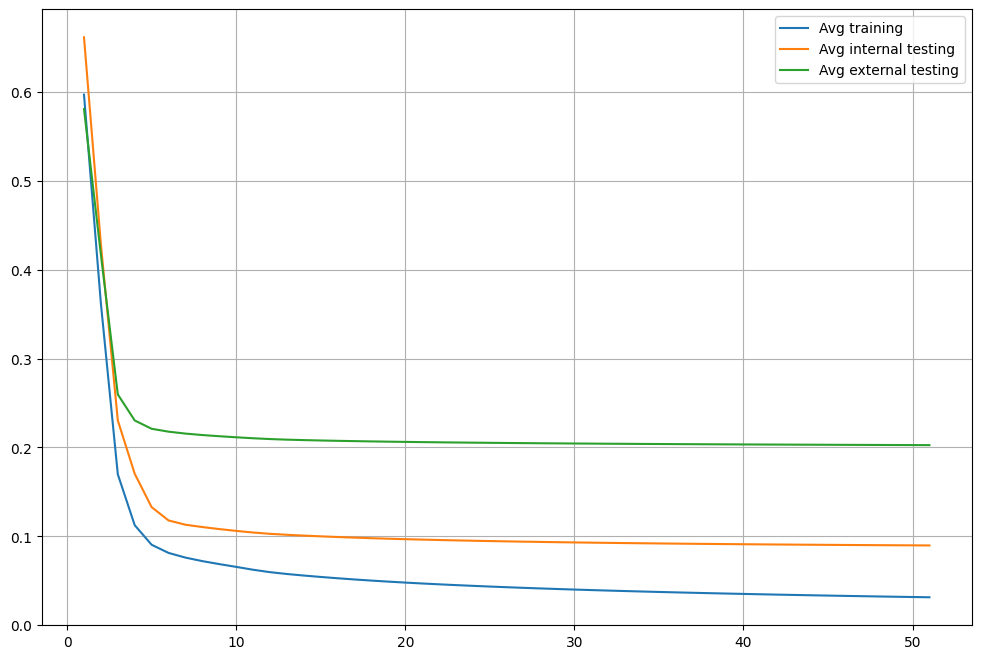

In [40]:
pd.options.display.float_format = None

K = 6

inputs         	= out_data_int
weights         = 2 * np.random.rand(K, len(inputs[0])) - 1
correct_outputs = out_labels_int
epochs        	= 50
LRA             = 0.01
LRB				= 0.95
LRD				= False

results_tr = np.zeros(K, dtype = object)
results_te = np.zeros(K, dtype = object)
results_ext_te = np.zeros(K, dtype = object)
P_ext = np.zeros((len(data_ext), epochs + 1), dtype = object)
avg_tr = np.zeros(epochs + 1)
avg_te = np.zeros(epochs + 1)

N = len(correct_outputs)
original_indices = np.arange(N)

indices = NN.data_folding(K, N)[1]


for ind in range(K):
	bool_train_set 					= np.ones(inputs.shape[0], dtype=bool)

	# Training data
	bool_train_set[indices == ind] 	= False
	train_indices 					= original_indices[bool_train_set]
	train_labels 					= correct_outputs[train_indices]
	train_data 						= inputs[train_indices, :]
	
	# Testing data
	bool_test_set 					= ~bool_train_set
	test_indices 					= original_indices[bool_test_set]
	test_labels 					= correct_outputs[test_indices]	
	test_data 						= inputs[test_indices, :]
	

	# TRAINING phase
	sq_tr_data = np.squeeze(train_data)
	results_tr[ind] = NN.training(
								weights 		= weights[ind, :], 
							   	inputs 			= sq_tr_data, 
							   	correct_outputs = train_labels, 
							   	epochs 			= epochs, 
							   	LRA 			= LRA,
								LRB				= LRB,
								LRD				= True
								)
	
	P = results_tr[ind]['P']
	E = results_tr[ind]['E']
	avg_tr += np.sum(np.abs(P - E), axis = 0) / (len(P[:, 0]) * K) 	



	# TESTING phase
	results_te[ind] = NN.trend_over_epochs(
										inputs = test_data, 
										correct_outputs = test_labels, 
										weights_per_epoch = results_tr[ind]['container_weights']
										)
	P = results_te[ind]['P']
	E = results_te[ind]['E']
	avg_te += np.sum(np.abs(P - E), axis = 0) / (len(P[:, 0]) * K) 	

	# TESTING esterno

	results_ext_te[ind] = NN.trend_over_epochs(
										inputs = data_ext, 
										correct_outputs = labels_ext, 
										weights_per_epoch = results_tr[ind]['container_weights']
										)
	P_ext += results_ext_te[ind]['P'] / K


# P = results_ext_te['P']
E = results_ext_te[0]['E']
avg_ext_te = np.sum(np.abs(P_ext - E), axis = 0) / len(P_ext[:, 0])



c_w = results_tr[1]['container_weights']
# P = results_tr[1]['P'][0]
# E = results_tr[1]['E'][0]

plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, len(c_w)+1), avg_tr, label = 'Avg training')
plt.plot(np.arange(1, len(c_w)+1), avg_te, label = 'Avg internal testing')
plt.plot(np.arange(1, len(c_w)+1), avg_ext_te, label = 'Avg external testing')
plt.grid()
plt.legend()
plt.show()

## PCA

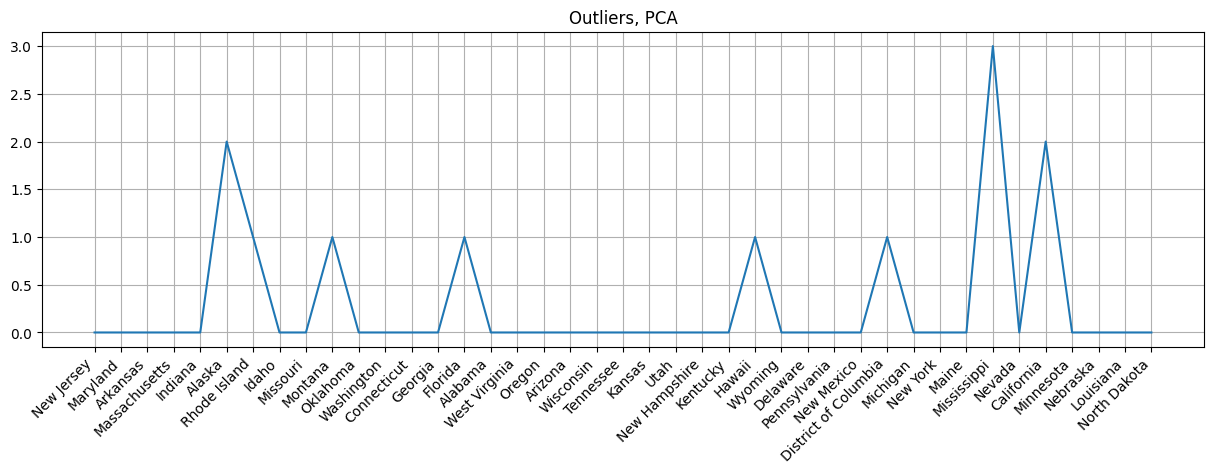

In [27]:
scaler = StandardScaler()
scaled_data_int = scaler.fit_transform(PCA_data_int)

# Ottengomo medie e deviazioni standard feature scalate
#
# feature_means = scaler.mean_
# feature_std = np.sqrt(scaler.var_)

outlier_pc = np.zeros(len(scaled_data_int))

for i, state in enumerate(scaled_data_int):
    outlier_pc[i] = 0
    for j, feat in enumerate(state):
        if np.abs(feat) > 2:
            outlier_pc[i] += 1

# Visualizza outliers
plt.figure(figsize=(15, 5))
plt.title(f'Outliers, PCA')
plt.subplots_adjust(bottom=0.25)
plt.xticks(range(0,len(scaled_data_int)), state_names_int, rotation=45, ha='right')
plt.plot(outlier_pc)
plt.grid()
plt.show()

In [28]:
# Percentuale feature outlier per essere considerato outlier
p_outlier = 0.3

# Vettore che mi indica la posizione degli outlier
outlier_idx = np.zeros(len(outlier_pc))

for i in range(len(outlier)) :
  if outlier_pc[i] > p_outlier * len(scaled_data_int[0]) :
    outlier_idx[i] = 1

outlier_idx = np.array(outlier_idx, dtype=bool)

PCA_out_data_int = np.delete(PCA_data_int, outlier_idx, axis=0)
PCA_out_labels_int = np.delete(labels_int, outlier_idx, axis=0)

### Training

K =  0
Accuracy    :  0.9999999999999999
Sensitivity :  0.9999999999999999
Specificity :  1.0
FN          :  0.0
FP          :  0.0 



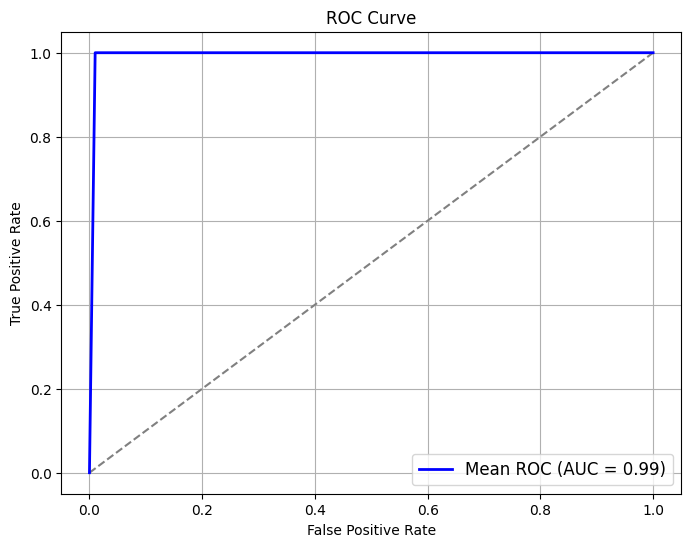

K =  1
Accuracy    :  0.9999999999999999
Sensitivity :  1.0
Specificity :  0.9999999999999999
FN          :  0.0
FP          :  0.0 



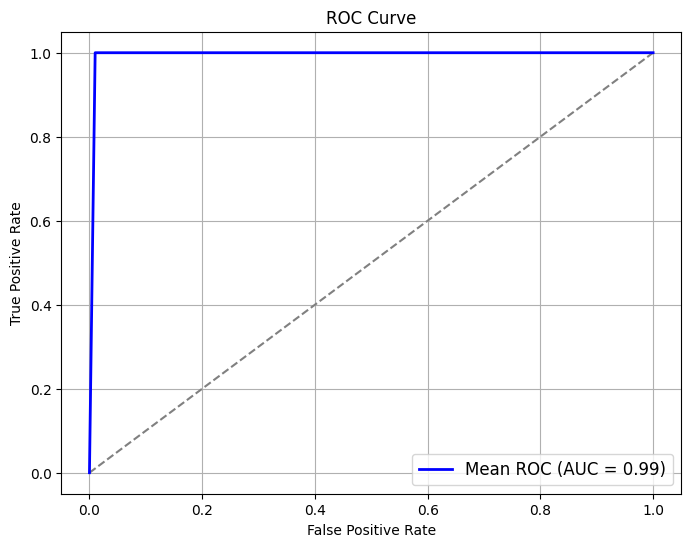

K =  2
Accuracy    :  0.8888888888888891
Sensitivity :  0.8
Specificity :  1.0
FN          :  0.2
FP          :  0.0 



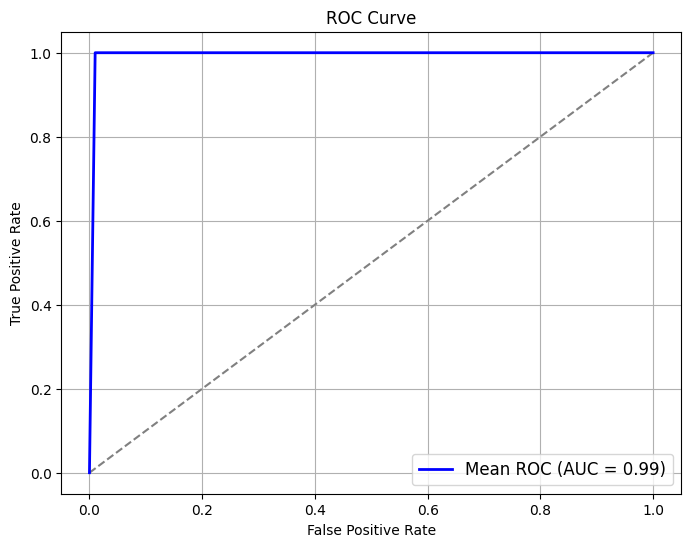

K =  3
Accuracy    :  0.8888888888888891
Sensitivity :  1.0
Specificity :  0.875
FN          :  0.0
FP          :  0.125 



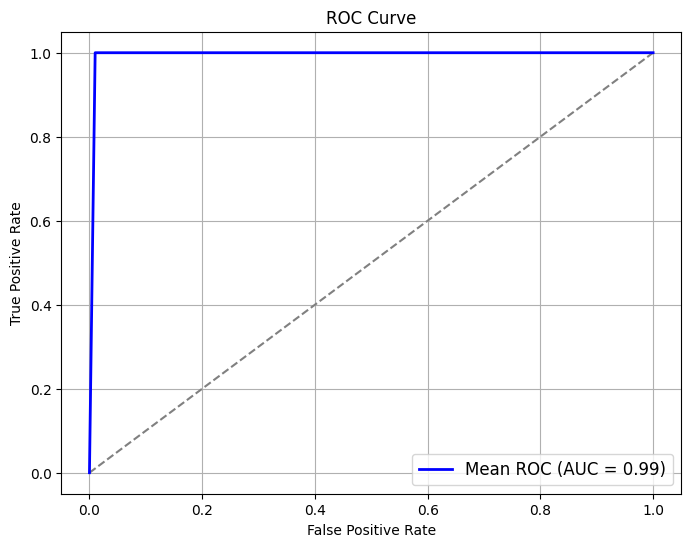

VALORI MEDI METRICHE
Accuracy    :  0.9444444444444444  +-  0.055555555555555414
Sensitivity :  0.95  +-  0.08660254037844384
Specificity :  0.96875  +-  0.0541265877365274
FN          :  0.05  +-  0.08660254037844388
FP          :  0.03125  +-  0.05412658773652741


In [41]:
pd.options.display.float_format = None

K = 4

inputs         	= PCA_out_data_int
weight          = 2 * np.random.rand(len(inputs[0])) - 1
weights         = np.ones((K, len(inputs[0]))) * weight
correct_outputs = PCA_out_labels_int               
epochs          = 50
LRA             = 0.01
LRB				= 0.95
LRD				= False

N = len(correct_outputs)

original_indices = np.arange(N)

fd = NN.data_folding(K, N)

K, index = fd

accuracy = np.zeros(4)
sensitivity = np.zeros(4)
specificity = np.zeros(4)
FN = np.zeros(4)
FP = np.zeros(4)

for ind in range(K):
	temp_train_set = np.ones(inputs.shape[0], dtype=bool)

	temp_train_set[index == ind] = False
	temp_test_set = ~temp_train_set
	
	temp_train_indices = original_indices[temp_train_set]
	temp_test_indices = original_indices[temp_test_set]
	
	temp_train_labels = PCA_out_labels_int[temp_train_indices]
	temp_test_labels = PCA_out_labels_int[temp_test_indices]
	
	temp_train_data = PCA_out_data_int[temp_train_indices, :]
	temp_test_data = PCA_out_data_int[temp_test_indices, :]
	
	pc_tr_data = np.squeeze(temp_train_data)
		
	results = NN.training(weights[ind,:], pc_tr_data, temp_train_labels, epochs, LRA = LRA, LRB = LRB, LRD = LRD)
	weights[ind, :] = results['container_weights'][-1]
	
	# TESTING phase
	temp_te_data = np.squeeze(temp_test_data)
	
	tested = NN.testing(temp_te_data, temp_test_labels, weights[ind, :])
	
	accuracy[ind] = tested[3]['accuracy']
	sensitivity[ind] = tested[3]['sensitivity']
	specificity[ind] = tested[3]['specificity']
	FN[ind] = tested[3]['FN']
	FP[ind] = tested[3]['FP']

	print('K = ', ind)
	print('Accuracy    : ', accuracy[ind])
	print('Sensitivity : ', sensitivity[ind])
	print('Specificity : ', specificity[ind])
	print('FN          : ', FN[ind])
	print('FP          : ', FP[ind], '\n')
	NN.ROC_curve(tested[1], tested[2])


accuracy_mean = np.mean(accuracy)
accuracy_std  = np.std(accuracy)

sensitivity_mean = np.mean(sensitivity)
sensitivity_std  = np.std(sensitivity)

specificity_mean = np.mean(specificity)
specificity_std  = np.std(specificity)

FN_mean = np.mean(FN)
FN_std  = np.std(FN)

FP_mean = np.mean(FP)
FP_std  = np.std(FP)

print('VALORI MEDI METRICHE')
print('Accuracy    : ', accuracy_mean, ' +- ', accuracy_std)
print('Sensitivity : ', sensitivity_mean, ' +- ', sensitivity_std)
print('Specificity : ', specificity_mean, ' +- ', specificity_std)
print('FN          : ', FN_mean, ' +- ', FN_std)
print('FP          : ', FP_mean, ' +- ', FP_std)

### Cost function variando epoche

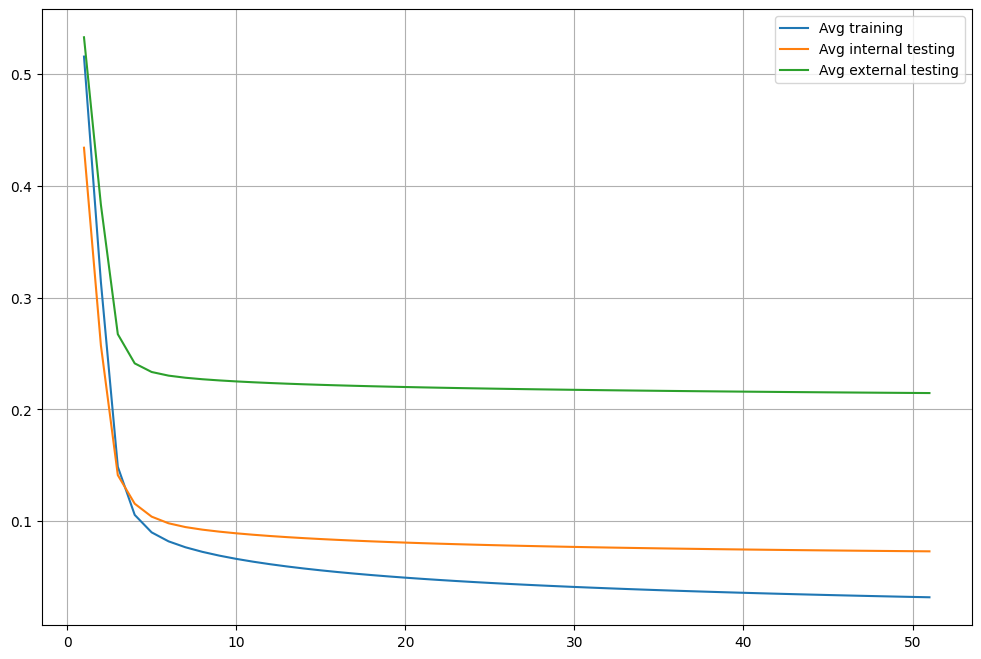

In [30]:
pd.options.display.float_format = None

K = 6

inputs         	= PCA_out_data_int
weights         = 2 * np.random.rand(K, len(inputs[0])) - 1
correct_outputs = inputs
epochs        	= 50
LRA             = 0.01
LRB				= 0.95
LRD				= False

results_tr = np.zeros(K, dtype = object)
results_te = np.zeros(K, dtype = object)
results_ext_te = np.zeros(K, dtype = object)
P_ext = np.zeros((len(PCA_data_ext), epochs + 1), dtype = object)
avg_tr = np.zeros(epochs + 1)
avg_te = np.zeros(epochs + 1)

N = len(correct_outputs)
original_indices = np.arange(N)

indices = NN.data_folding(K, N)[1]


for ind in range(K):
	bool_train_set 					= np.ones(inputs.shape[0], dtype=bool)

	# Training data
	bool_train_set[indices == ind] 	= False
	train_indices 					= original_indices[bool_train_set]
	train_labels 					= correct_outputs[train_indices]
	train_data 						= inputs[train_indices, :]
	
	# Testing data
	bool_test_set 					= ~bool_train_set
	test_indices 					= original_indices[bool_test_set]
	test_labels 					= correct_outputs[test_indices]	
	test_data 						= inputs[test_indices, :]
	

	# TRAINING phase
	sq_tr_data = np.squeeze(train_data)
	results_tr[ind] = NN.training(
								weights 		= weights[ind, :], 
							   	inputs 			= sq_tr_data, 
							   	correct_outputs = train_labels, 
							   	epochs 			= epochs, 
							   	LRA 			= LRA,
								LRB				= LRB,
								LRD				= True
								)
	
	P = results_tr[ind]['P']
	E = results_tr[ind]['E']
	avg_tr += np.sum(np.abs(P - E), axis = 0) / (len(P[:, 0]) * K) 	



	# TESTING phase
	results_te[ind] = NN.trend_over_epochs(
										inputs = test_data, 
										correct_outputs = test_labels, 
										weights_per_epoch = results_tr[ind]['container_weights']
										)
	P = results_te[ind]['P']
	E = results_te[ind]['E']
	avg_te += np.sum(np.abs(P - E), axis = 0) / (len(P[:, 0]) * K) 	

	# TESTING esterno

	results_ext_te[ind] = NN.trend_over_epochs(
										inputs = PCA_data_ext, 
										correct_outputs = labels_ext, 
										weights_per_epoch = results_tr[ind]['container_weights']
										)
	P_ext += results_ext_te[ind]['P'] / K


# P = results_ext_te['P']
E = results_ext_te[0]['E']
avg_ext_te = np.sum(np.abs(P_ext - E), axis = 0) / len(P_ext[:, 0])



c_w = results_tr[1]['container_weights']
# P = results_tr[1]['P'][0]
# E = results_tr[1]['E'][0]

plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, len(c_w)+1), avg_tr, label = 'Avg training')
plt.plot(np.arange(1, len(c_w)+1), avg_te, label = 'Avg internal testing')
plt.plot(np.arange(1, len(c_w)+1), avg_ext_te, label = 'Avg external testing')
plt.grid()
plt.legend()
plt.show()